In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
plt.rcParams.update({'font.size': 16})
plt.figure()

def forward(x, W, P, Wc, c):
#     print((W@x).shape)
#     print(Wc[:, c][None].T.repeat(1,6).shape)
    states = torch.concatenate((W @ x, Wc[:, c][None].T.repeat(1,6)), dim=0)
    output = (P @ states)
    return output


def fig_MDS(W1, W2, P, Wc, scale, plot=True):
    list1_length = list2_length = 6
    data = torch.eye(list1_length)
    output1 = forward(data, W1, P, Wc, 0)
    output2 = forward(data, W2, P, Wc, 1)

    # Combine the tensors
    data = np.hstack((output1, output2))  # Assuming you want the first 5 columns of each

    # Perform MDS
    mds = MDS(n_components=2, random_state=0)
    data_2d = mds.fit_transform(data.T)  # Transpose because MDS expects samples as rows
    data_2d[:, [0, 1]] = data_2d[:, [1, 0]]

    if plot:
        # Plot
        fig, ax = plt.subplots(figsize=(5,5),dpi=300)
        dot_size = 400  # Dot size
        dot_edge_width = 3  # Make the dot border thick

        # Plot the lines with a lower zorder
        for i in range(1, list1_length):
            ax.plot(data_2d[i-1:i+1, 0], data_2d[i-1:i+1, 1], color='tab:blue', linewidth=2, zorder=1)
        for i in range(list1_length+1, list1_length+list2_length):
            ax.plot(data_2d[i-1:i+1, 0], data_2d[i-1:i+1, 1], color='tab:orange', linewidth=2, zorder=1)

        # Plot the dots and text with a higher zorder
        for i, point in enumerate(data_2d[:list1_length, :]):
            ax.scatter(point[0], point[1], s=dot_size, edgecolor='tab:blue', facecolor='white', linewidth=dot_edge_width, zorder=2)
            ax.text(point[0], point[1], str(i+1), color='tab:blue', ha='center', va='center', fontweight='bold', zorder=3)

        for i, point in enumerate(data_2d[list1_length:, :]):
            ax.scatter(point[0], point[1], s=dot_size, edgecolor='tab:orange', facecolor='white', linewidth=dot_edge_width, zorder=2)
            ax.text(point[0], point[1], str(i+1), color='tab:orange', ha='center', va='center', fontweight='bold', zorder=3)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    #     plt.axis('equal')
        ticks = [-scale, scale]

        # Set the same ticks on both axes
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        plt.xlabel('dimension 1')
        plt.ylabel('dimension 2')


        plt.show()
    
        return output1, output2
    else:
        return data_2d.max(), output1, output2


import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
plt.rcParams.update({'font.size': 16})

def plot_heat_map(output1, output2, max_v, plot=True):
    # Correct the labels for the axis to include '6', 'F'
    labels = ['1', '2', '3', '4', '5', '6', '1', '2', '3', '4', '5', '6']

    # Since we added two more labels, we need to regenerate the data and distances
    # Generate random data for 12 points with 100 dimensions
    all_data_corrected = np.concatenate((output1, output2), axis=1)

    # Compute pairwise L2 (Euclidean) distance matrix for the corrected data
    distances_corrected = cdist(all_data_corrected.T, all_data_corrected.T, 'euclidean')

    # Set the distances on the main diagonal to zero for the corrected data
    np.fill_diagonal(distances_corrected, 0)
    if plot:
        # Plotting the heatmap with the corrected settings
        fig, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
        heatmap_corrected = ax.imshow(distances_corrected, cmap='inferno', origin='upper',vmin=0,vmax=max_v)

        # Adding color bar on the side
        cbar = fig.colorbar(heatmap_corrected, ticks=[0, max_v])
        cbar.set_label('L2 distance', rotation=270, labelpad=20)#, labelpad=-20)

        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Apply custom styling for each label
        for index, label in enumerate(labels):
            if index < 6:  # First 6 indexes
                color = 'tab:blue'
            else:  # Last 6 indexes
                color = 'tab:orange'

            # Set custom x-axis labels
            ax.text(index, 12, label, va='center', ha='center', color=color, fontweight='bold')

            # Set custom y-axis labels (considering the reversed axis)
            ax.text(-1, index, label, va='center', ha='right', color=color, fontweight='bold')



        # Turning off the grid
        ax.grid(False)

        # Show the plot
        plt.show()
        print(distances_corrected.max())
    else:
        return distances_corrected.max()
    
    
output1, output2 = fig_MDS(W1, W2, P, Wc, 10)
plot_heat_map(output1, output2, 15)

NameError: name 'W1' is not defined

<Figure size 640x480 with 0 Axes>

In [4]:
import torch
import numpy as np

def average_cosine(vectors):

    # Normalize each vector
    vectors_norm = vectors / vectors.norm(dim=1, keepdim=True)

    # Compute the cosine similarity matrix (dot product of normalized vectors)
    cosine_similarities = vectors_norm @ vectors_norm.T

    # Extract the upper triangle of the matrix, excluding the diagonal
    num_objects = vectors.shape[0]
    i, j = torch.triu_indices(num_objects, num_objects, offset=1)
    cosine_similarities_upper = cosine_similarities[i, j]
    # Calculate the average cosine similarity
    average_cosine = cosine_similarities_upper.mean().item()

    
    return average_cosine


def gen_W(num_objects, dim, target_cosine):
    # Define ranges
    sparsity_range = (0.002, 0.01)
    # Initialize the vectors tensor with random sparsity
    vectors = torch.zeros((num_objects, dim), dtype=torch.float)
    num_ones = torch.randint(int(sparsity_range[0] * dim), int(sparsity_range[1] * dim + 1), (num_objects,))
    for i in range(num_objects):
        ones_indices = torch.randperm(dim)[:num_ones[i]]
        vectors[i, ones_indices] = 1

    cos = average_cosine(vectors)
    if target_cosine==0 and cos!=0:
        vectors = torch.zeros((num_objects, dim), dtype=torch.float)
        num_ones = torch.randint(int(sparsity_range[0] * dim), int(sparsity_range[1] * dim + 1), (num_objects,))
        for i in range(num_objects):
            ones_indices = torch.randperm(dim)[:num_ones[i]]
            vectors[i, ones_indices] = 1

        cos = average_cosine(vectors)
        

    while(cos<target_cosine):
        # Randomly pick a pair of objects i and j
        indices = torch.randperm(num_objects)[:2]
        i, j = indices[0], indices[1]
        vi = vectors[i, :]
        vj = vectors[j, :]

        # Identify dimensions where only one of them has a 1 using XOR
        diff_indices = torch.nonzero(vi.int() ^ vj.int()).flatten()
        if len(diff_indices) > 0:
            # Randomly pick one such dimension
            dim_to_change = diff_indices[torch.randint(len(diff_indices), (1,)).item()]
        else:
            continue

        # Determine which vector has 0 at the chosen dimension
        if vi[dim_to_change] == 0:
            index_to_modify = i
        else:
            index_to_modify = j

        # Set the value of this object at the chosen dimension to 1
        vectors[index_to_modify, dim_to_change] = 1

        # Find a dimension in the same object that currently equals 1
        ones_indices = torch.nonzero(vectors[index_to_modify] == 1).flatten()
        ones_indices = ones_indices[ones_indices != dim_to_change]  # Exclude the modified dimension

        # Randomly pick one such dimension to set to 0
        dim_to_zero = ones_indices[torch.randint(len(ones_indices), (1,)).item()]
        vectors[index_to_modify, dim_to_zero] = 0

        # Compute the average cosine again
        cos = average_cosine(vectors)
#     print(cos)
    return vectors.T



In [5]:
len(pairs1)

30

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Ground truth ranking: [0, 1, 2, 3, 4, 5]
Learned ranking: [0, 1, 2, 3, 4, 5]
Mean v values: [-3.19999909 -2.10006571 -0.50001383  0.80402231  2.49500489  3.60001802]
Ground truth ranking: [0, 1, 2, 3, 4, 5]
Learned ranking: [0, 1, 2, 3, 4, 5]
Mean v values: [-3.2849853  -2.00001407 -0.69998366  0.80002868  2.0999949   3.65605855]
34.321799280474735


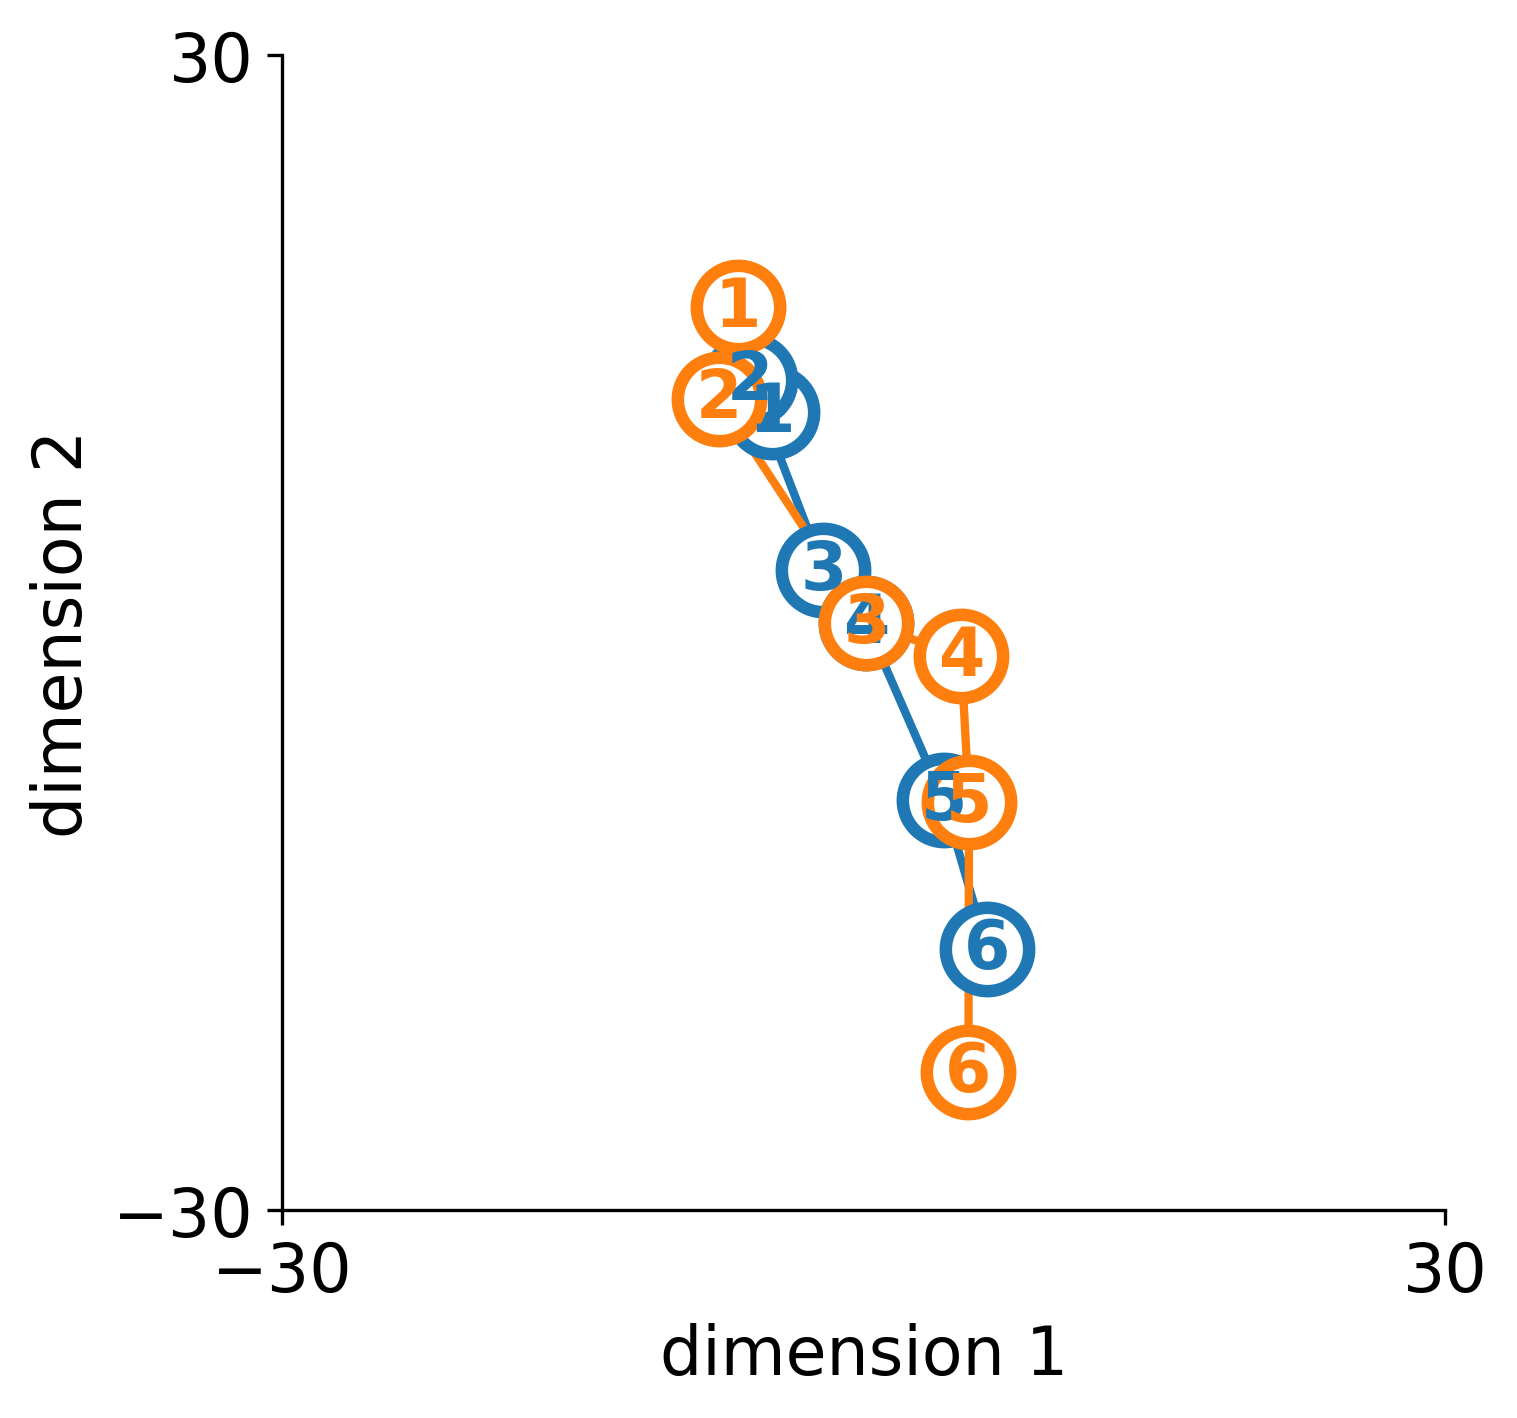

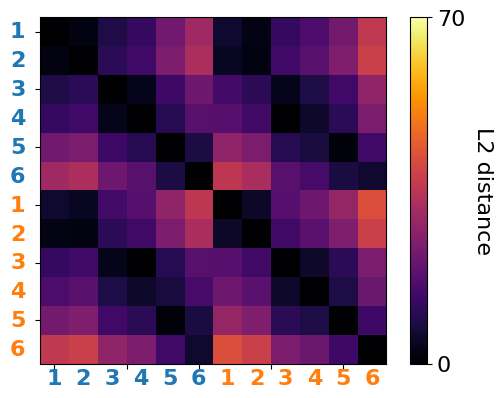

41.52567327723068


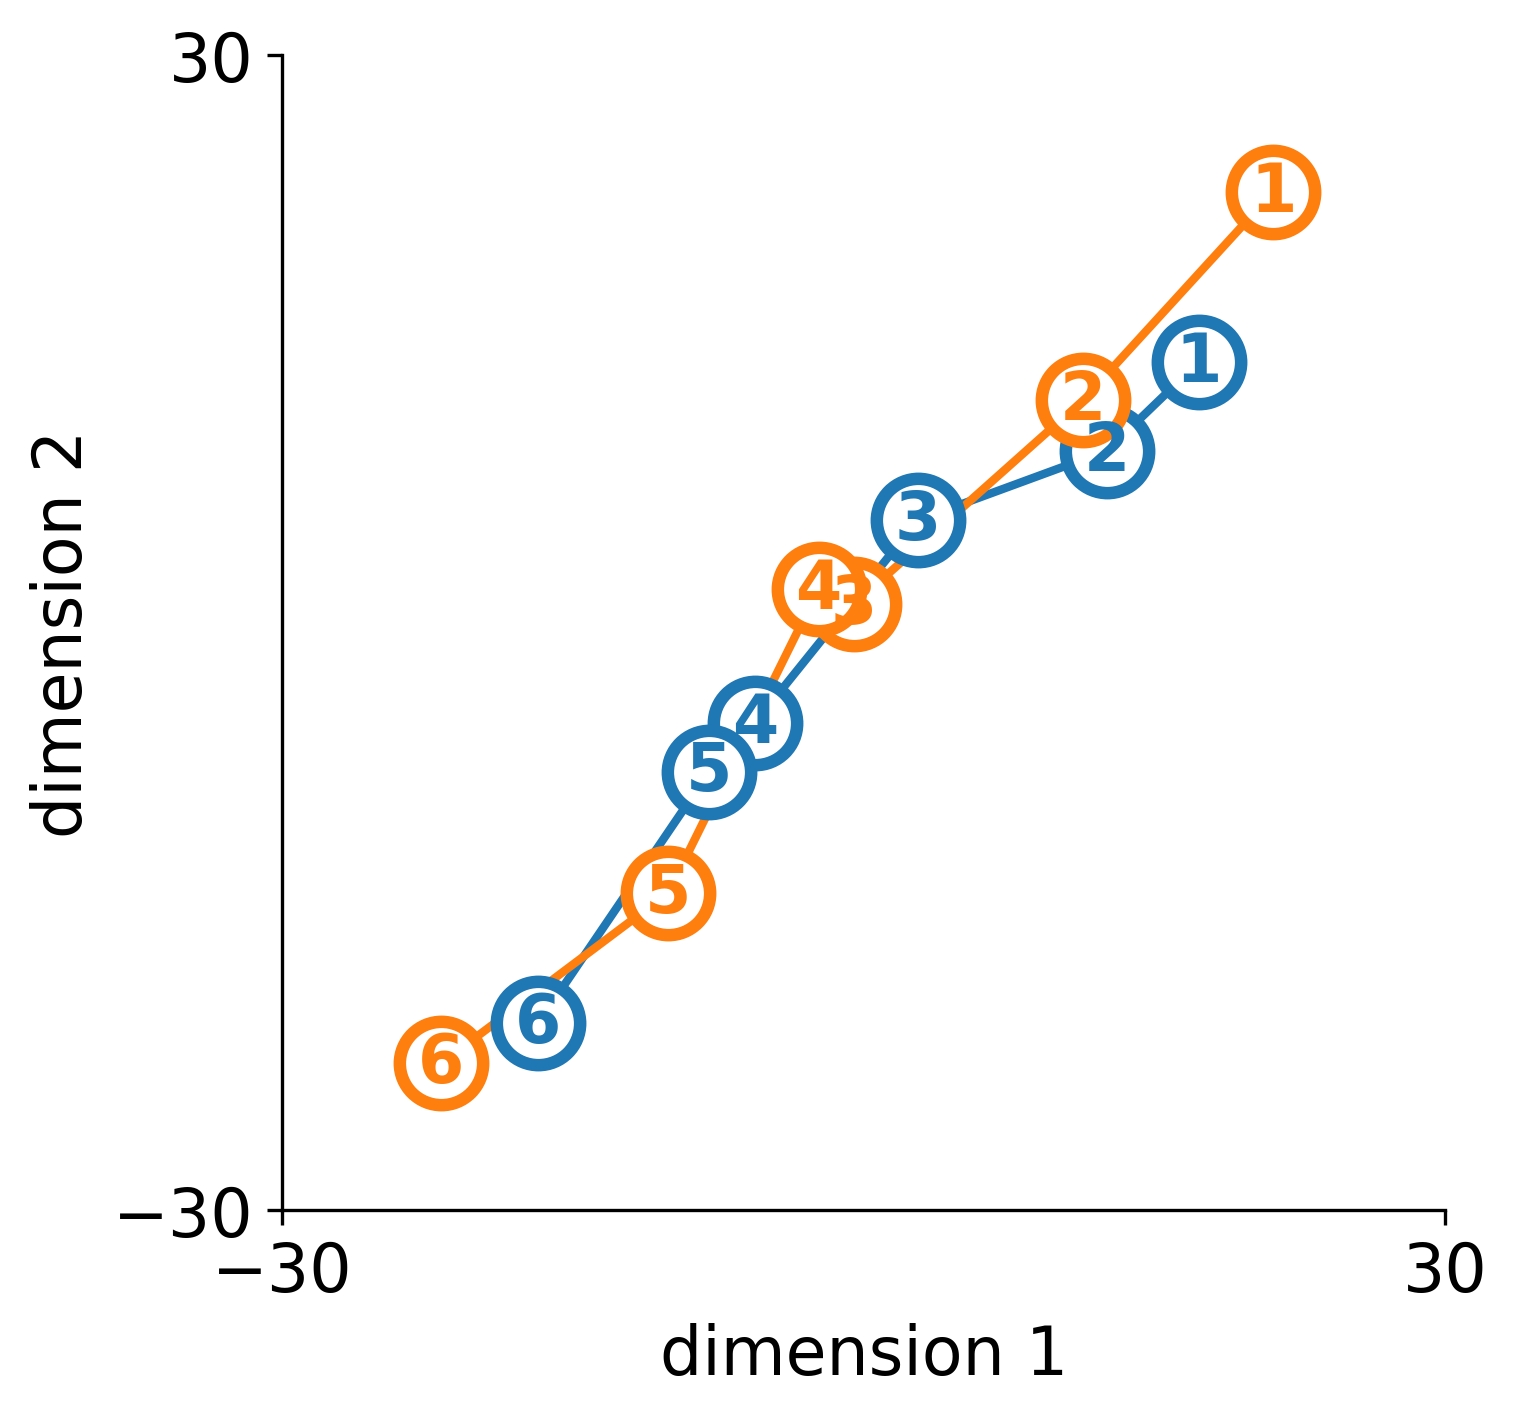

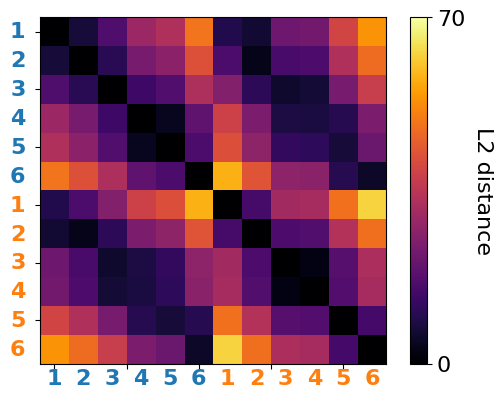

62.46681572136815


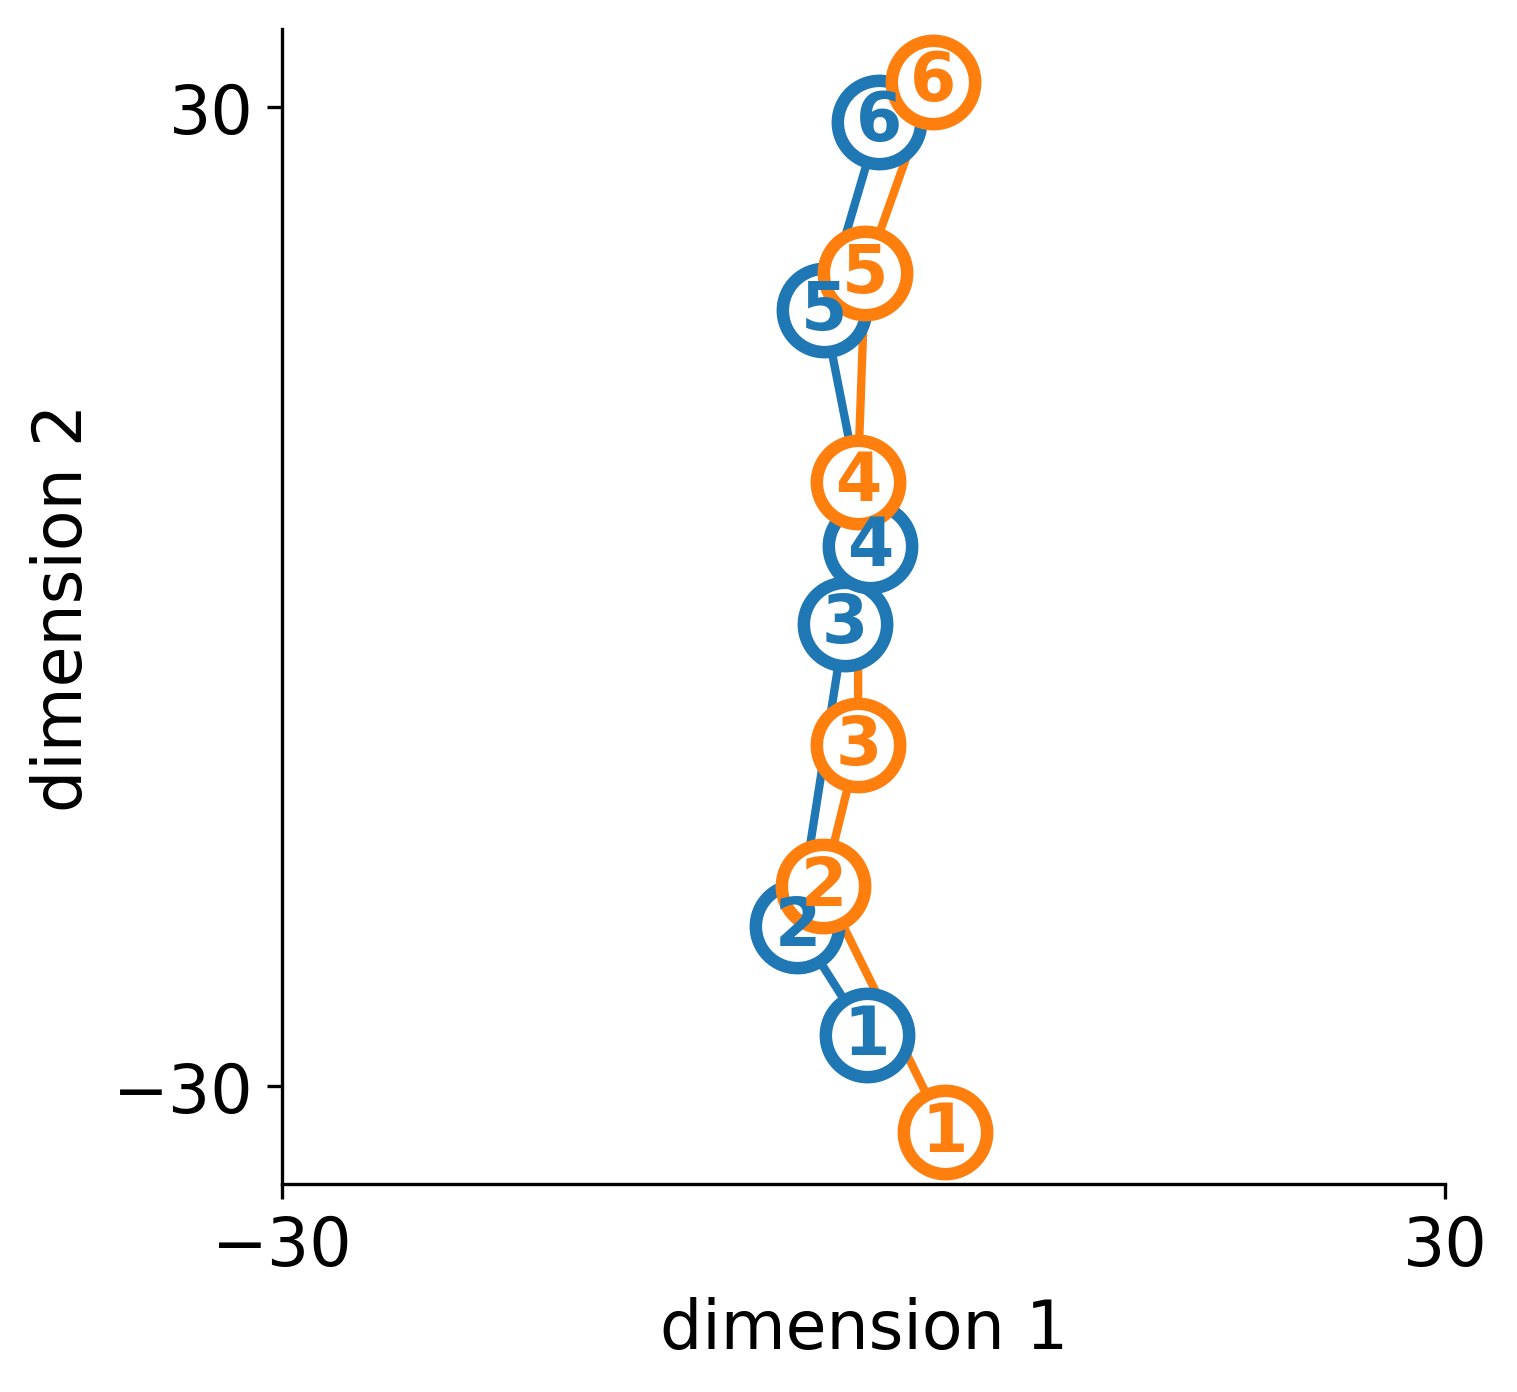

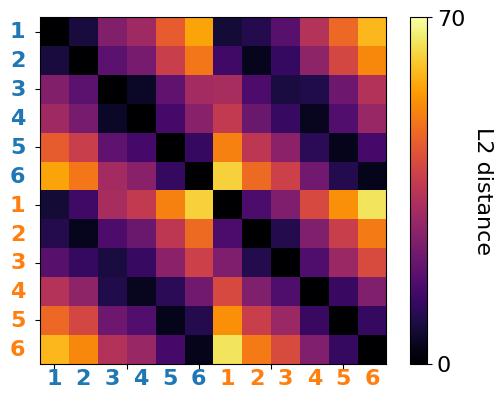

64.98953716345015


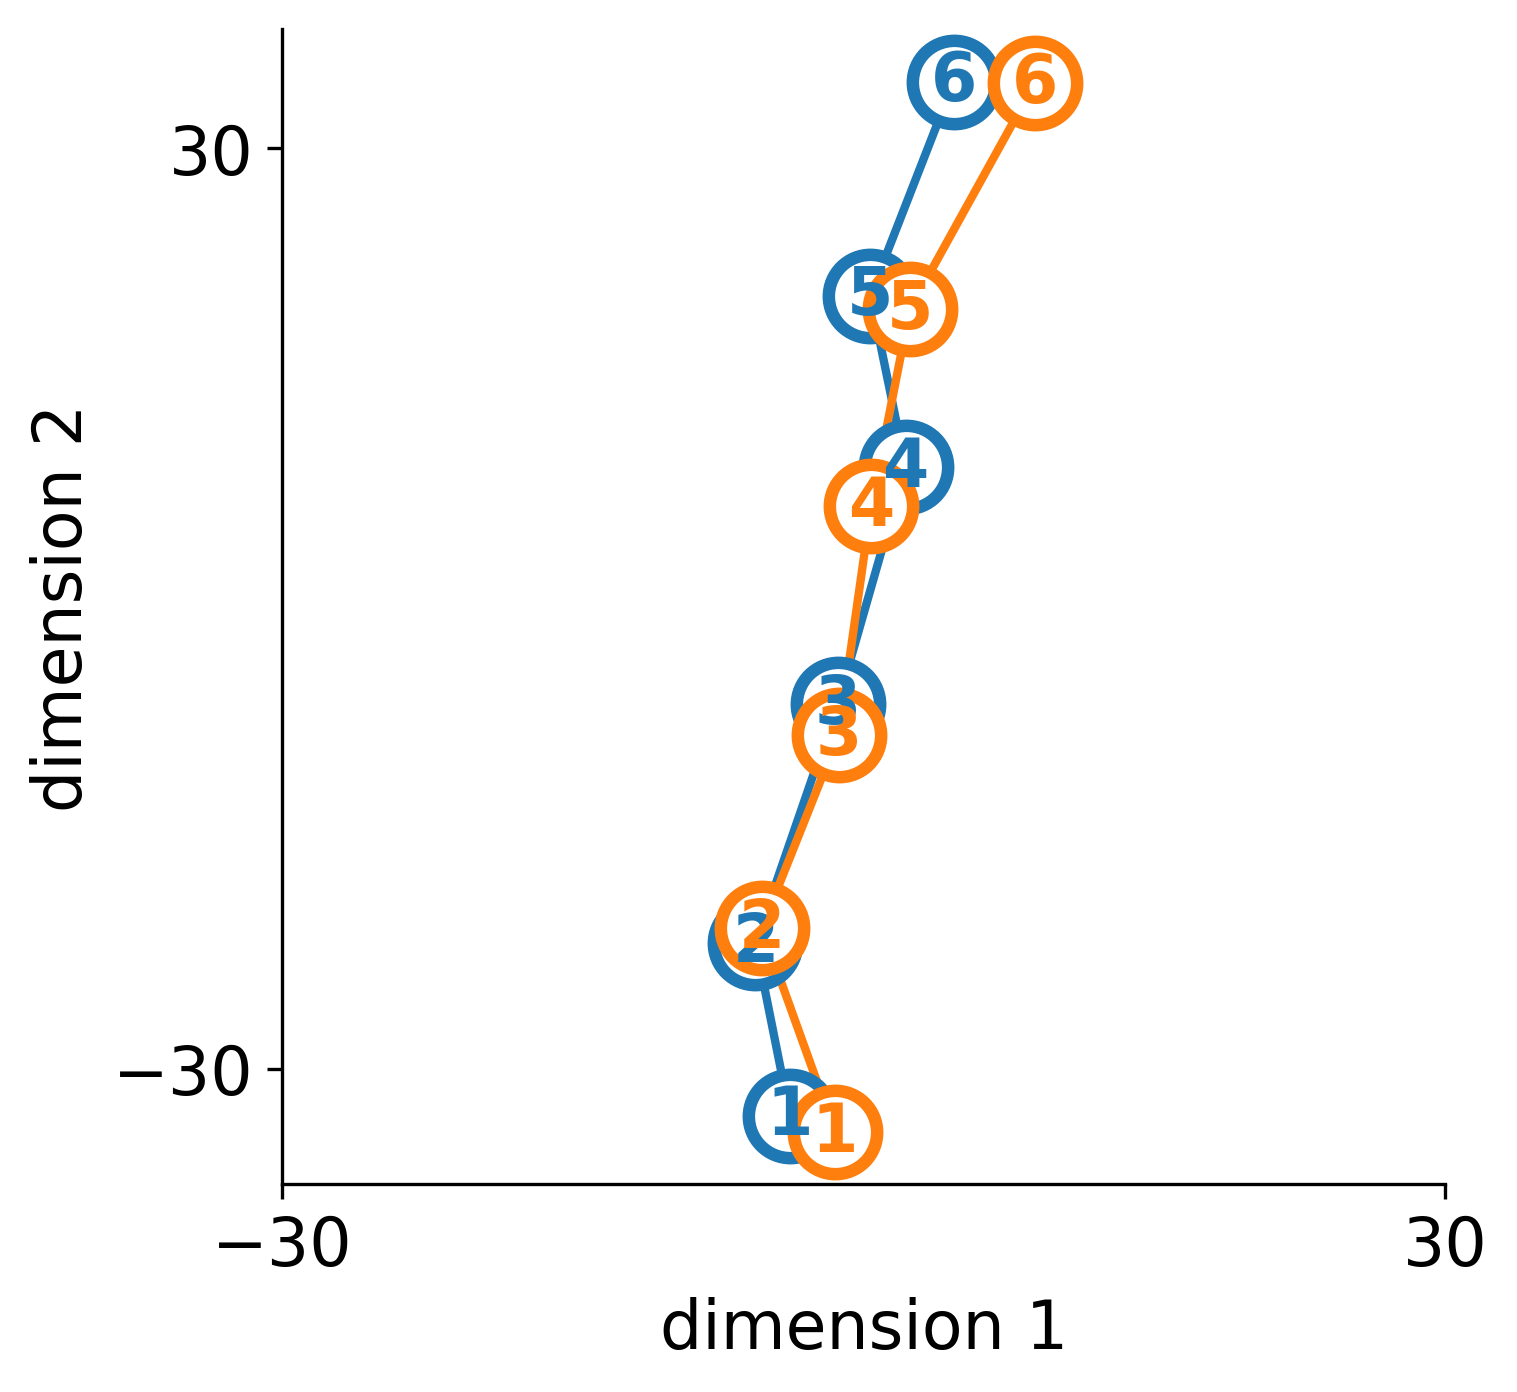

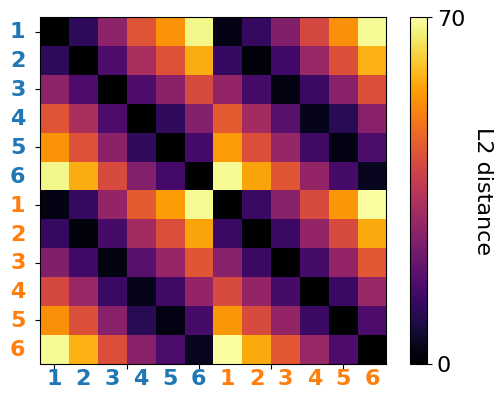

69.708108218554


In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

# Define the number of objects and dimensions
num_objects = 6
input_dim = num_objects
context_dim = 2
hidden_dim = 1000
hidden_context_dim = 1000
output_dim = 100

# Ground truth ranking
ground_truth_ranking1 = [0,1,2,3,4,5]
ground_truth_ranking2 = [0,1,2,3,4,5]

# Create all possible pairs of objects
pairs1 = [(i, j) for i in range(num_objects) for j in range(num_objects) if i != j]
labels1 = [(1 if ground_truth_ranking1.index(i) < ground_truth_ranking1.index(j) else -1) for i, j in pairs1]
pairs2 = [(i, j) for i in range(num_objects) for j in range(num_objects) if i != j]
labels2 = [(1 if ground_truth_ranking2.index(i) < ground_truth_ranking2.index(j) else -1) for i, j in pairs2]

# One-hot encode the input
one_hot_vectors1 = torch.eye(num_objects)
one_hot_vectors2 = torch.eye(num_objects)

one_hot_context = torch.eye(context_dim)

# Initialize W (fixed, random)
# W1 = torch.randn(hidden_dim, input_dim)
# W2 = torch.randn(hidden_dim, input_dim)

# Wc = 10.*torch.randn(hidden_context_dim, context_dim) 
cos=0
W1 = gen_W(num_objects, hidden_dim, cos)
W2 = gen_W(num_objects, hidden_dim, cos)
Wc = gen_W(context_dim, hidden_context_dim, cos)

# Initialize P (trainable)
P = torch.randn(output_dim, hidden_dim+hidden_context_dim) * 0.0001

# Learning rate
eta = 0.1

# Number of epochs
num_epochs = 10

# Define the error function
def error_function(v_i, v_j, label):
    error = torch.sign(torch.maximum((label * (v_i - v_j) +1), torch.tensor(0))*label)
    return error

# Track the mean of v for each object over epochs
mean_v_values1 = np.zeros((num_epochs*len(pairs1)+1, num_objects))
mean_v_values2 = np.zeros((num_epochs*len(pairs1)+1, num_objects))

for i in range(num_objects):
    s_i1_s = W1 @ one_hot_vectors1[i]
    s_i1_c = Wc @ one_hot_context[0]
    v_i1 = P @ torch.concatenate((s_i1_s,s_i1_c))
    mean_v_values1[0, i] = v_i1.mean().item()

    s_i2_s = W2 @ one_hot_vectors2[i]
    s_i2_c = Wc @ one_hot_context[1]
    v_i2 = P @ torch.concatenate((s_i2_s,s_i2_c))
    mean_v_values2[0, i] = v_i2.mean().item()
        
# Training loop
errors = []
iters=0
P_record = []
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    if epoch in [1,3,5,9]:
        P_record += [P.clone()]
    epoch_error = 0
    pairs2, labels2 = shuffle(pairs2, labels2)
    pairs1, labels1 = shuffle(pairs1, labels1)
    for (i1, j1), label1, (i2, j2), label2 in zip(pairs1, labels1, pairs2, labels2):
        #first linear order
        s_i1_s = W1 @ one_hot_vectors1[i1]
        s_j1_s = W1 @ one_hot_vectors1[j1]
        s_i1_c = Wc @ one_hot_context[0]
        s_j1_c = Wc @ one_hot_context[0]
        
        s_i1 = torch.concatenate((s_i1_s,s_i1_c))
        s_j1 = torch.concatenate((s_j1_s,s_i1_c))

        v_i1 = P @ s_i1
        v_j1 = P @ s_j1

        e1 = error_function(v_i1, v_j1, label1)
        epoch_error += e1.mean().item()
        P += eta * torch.outer(e1, (s_j1-s_i1))
        
        #second linear order
        s_i2_s = W2 @ one_hot_vectors2[i2]
        s_j2_s = W2 @ one_hot_vectors2[j2]
        s_i1_c = Wc @ one_hot_context[1]
        s_j1_c = Wc @ one_hot_context[1]
        
        s_i2 = torch.concatenate((s_i2_s,s_i2_c))
        s_j2 = torch.concatenate((s_j2_s,s_i2_c))


        v_i2 = P @ s_i2
        v_j2 = P @ s_j2

        e2 = error_function(v_i2, v_j2, label2)
        epoch_error += e2.mean().item()

        P += eta * torch.outer(e2, (s_j2-s_i2))
        # Compute the mean v values for each object
        for i in range(num_objects):
            s_i1_s = W1 @ one_hot_vectors1[i]
            s_i1_c = Wc @ one_hot_context[0]
            v_i1 = P @ torch.concatenate((s_i1_s,s_i1_c))
            mean_v_values1[iters+1, i] = v_i1.mean().item()

            s_i2_s = W2 @ one_hot_vectors2[i]
            s_i2_c = Wc @ one_hot_context[1]
            v_i2 = P @ torch.concatenate((s_i2_s,s_i2_c))
            mean_v_values2[iters+1, i] = v_i2.mean().item()
        iters+=1

    errors.append(epoch_error / (num_objects*2))



# Print the final results
summed_v_values1 = mean_v_values1[-1, :]
learned_ranking1 = sorted(range(num_objects), key=lambda i: summed_v_values1[i])

summed_v_values2 = mean_v_values2[-1, :]
learned_ranking2 = sorted(range(num_objects), key=lambda i: summed_v_values2[i])

print(f"Ground truth ranking: {ground_truth_ranking1}")
print(f"Learned ranking: {learned_ranking1}")
print(f"Mean v values: {summed_v_values1}")

print(f"Ground truth ranking: {ground_truth_ranking2}")
print(f"Learned ranking: {learned_ranking2}")
print(f"Mean v values: {summed_v_values2}")
max_mds = 0
max_heat = 0 
for P in P_record:
    _mds,output1, output2 = fig_MDS(W1, W2, P, Wc, 10, False)
    if _mds>max_mds:
        max_mds = _mds
    _heat = plot_heat_map(output1, output2, 99, False)
    if _heat>max_heat:
        max_heat = _heat
print(max_mds)
for P in P_record:
    output1, output2 = fig_MDS(W1, W2, P, Wc, round(max_mds, -1))
    plot_heat_map(output1, output2, round(max_heat, 0))

Training Progress:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth ranking: [0, 1, 2, 3, 4, 5]
Learned ranking: [0, 1, 2, 3, 4, 5]
Mean v values: [-3.15977383 -2.4642849  -1.96207011 -1.52915919 -1.06911075 -0.79019022]
Ground truth ranking: [0, 1, 2, 3, 4, 5]
Learned ranking: [0, 1, 2, 3, 4, 5]
Mean v values: [0.19337979 0.44220257 0.79582769 1.22334743 1.5217545  2.29707575]
26.56217966089619
43.164769327667116
49.97183126274626
52.76272662411525
53.90699406236791
max: 53.90699406236791


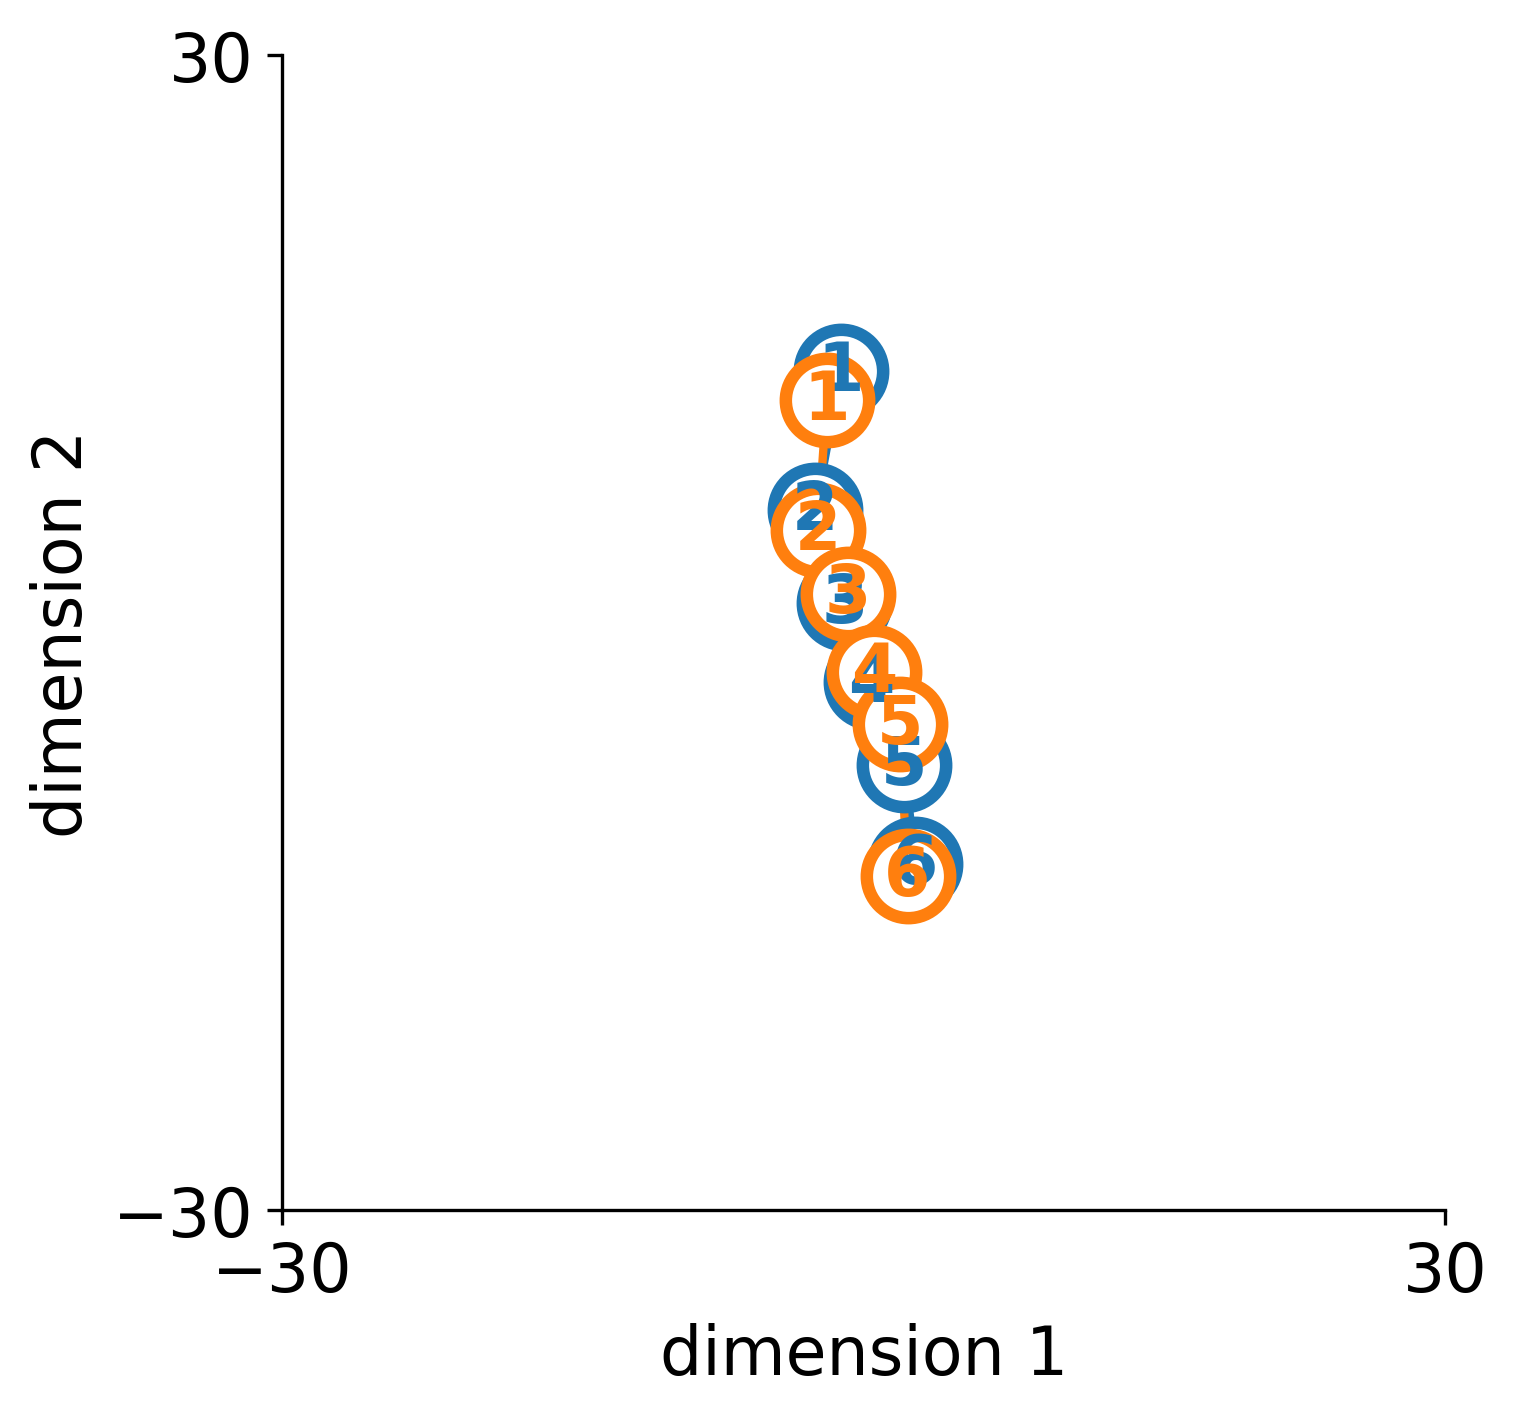

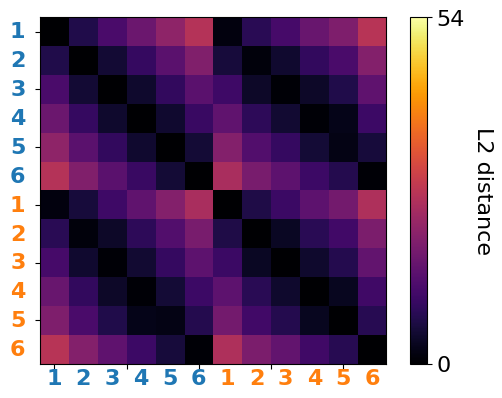

26.56217966089619


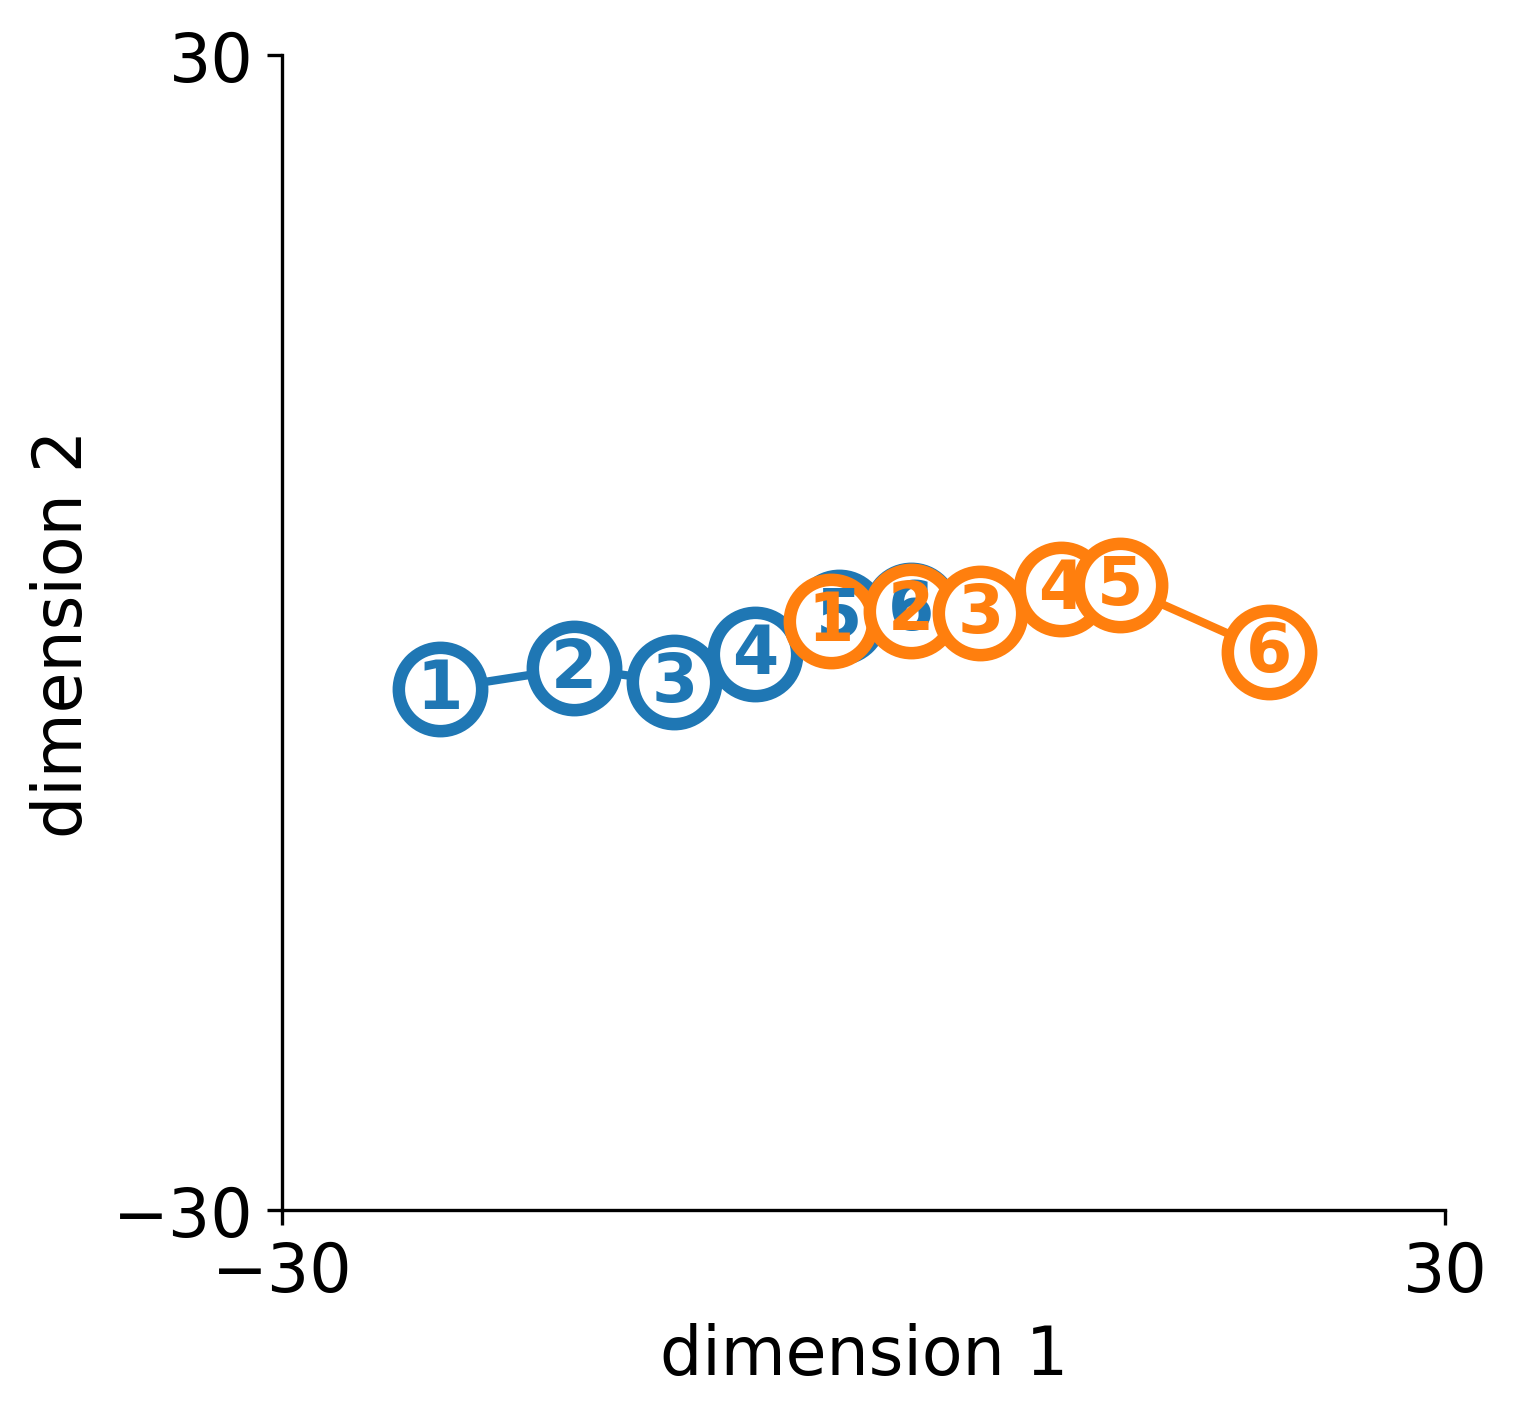

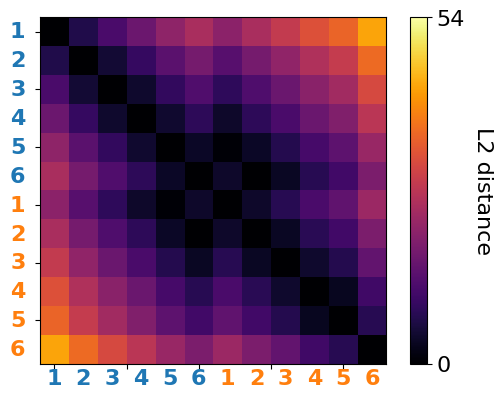

43.164769327667116


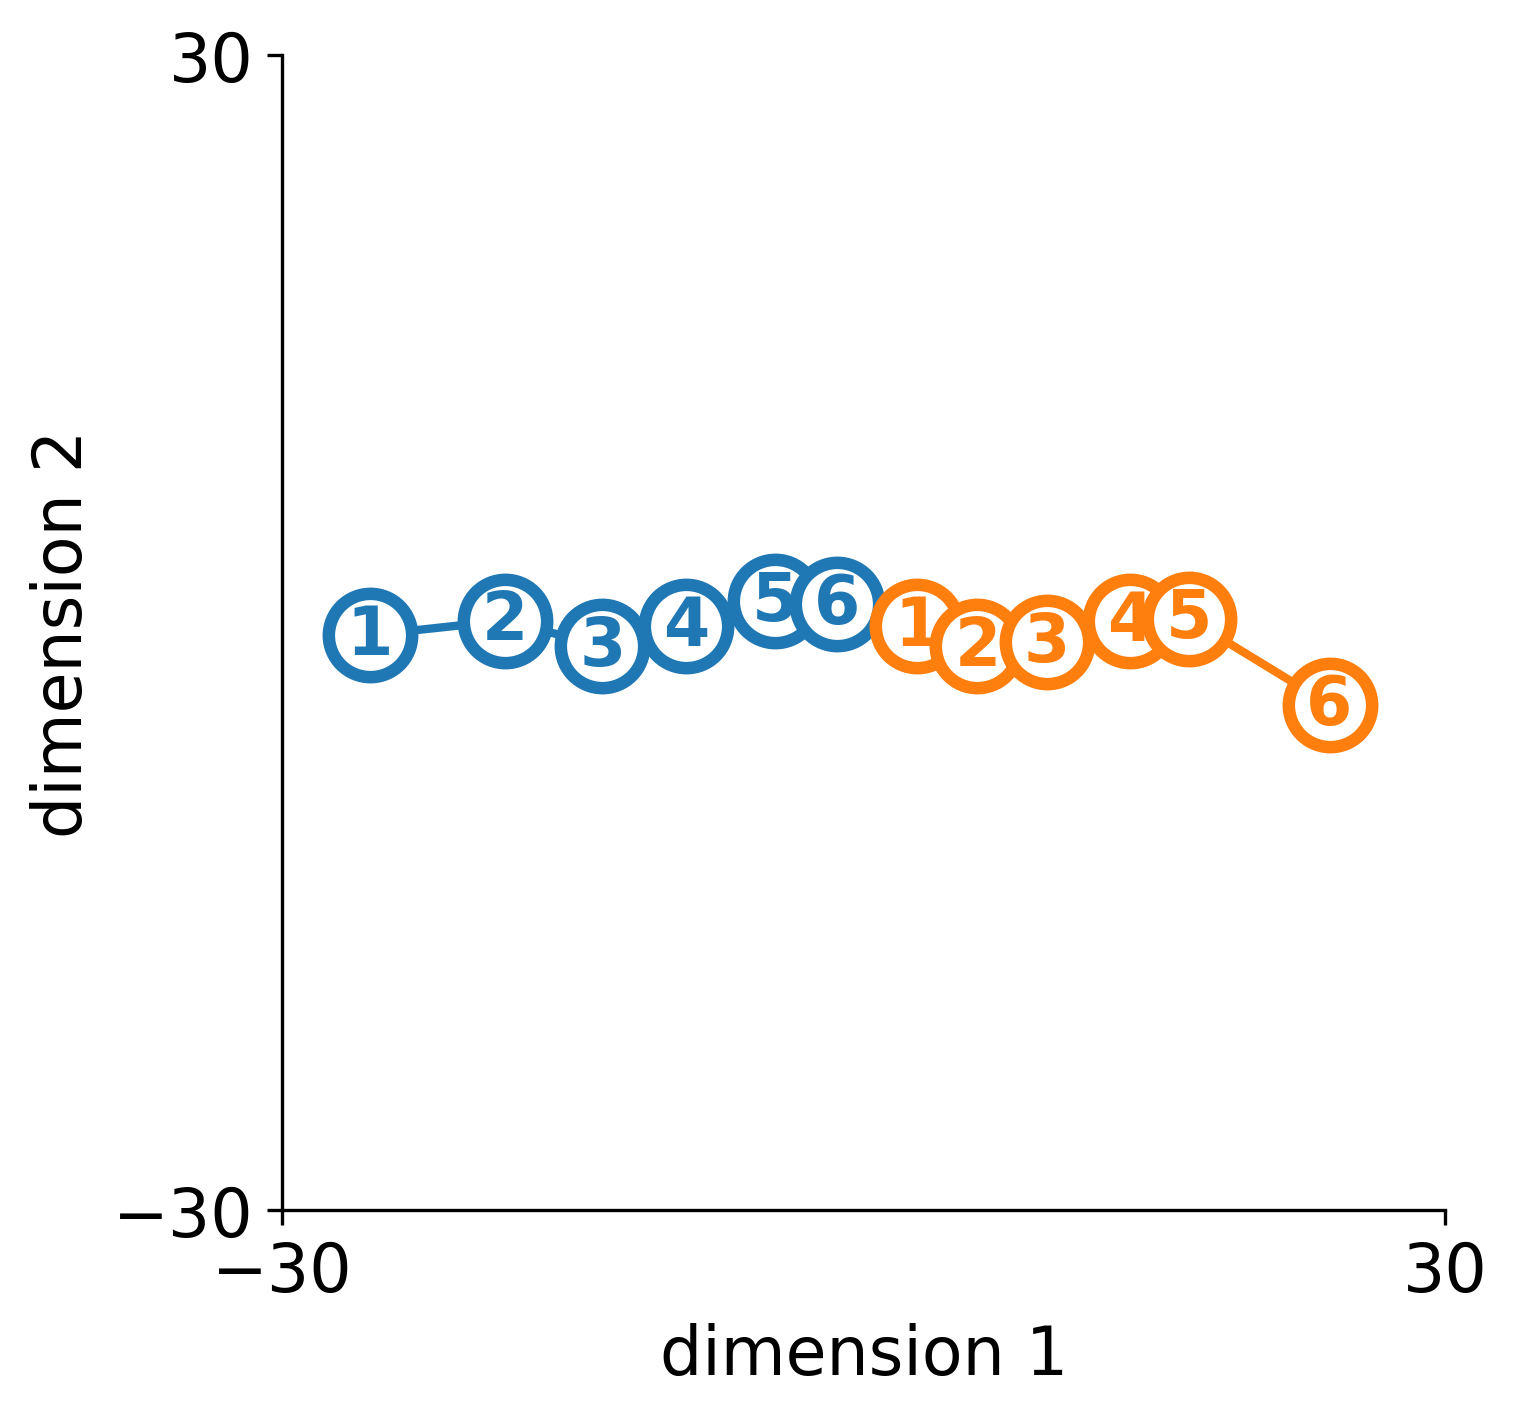

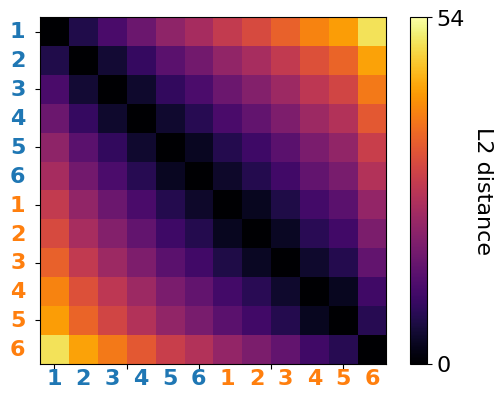

49.97183126274626


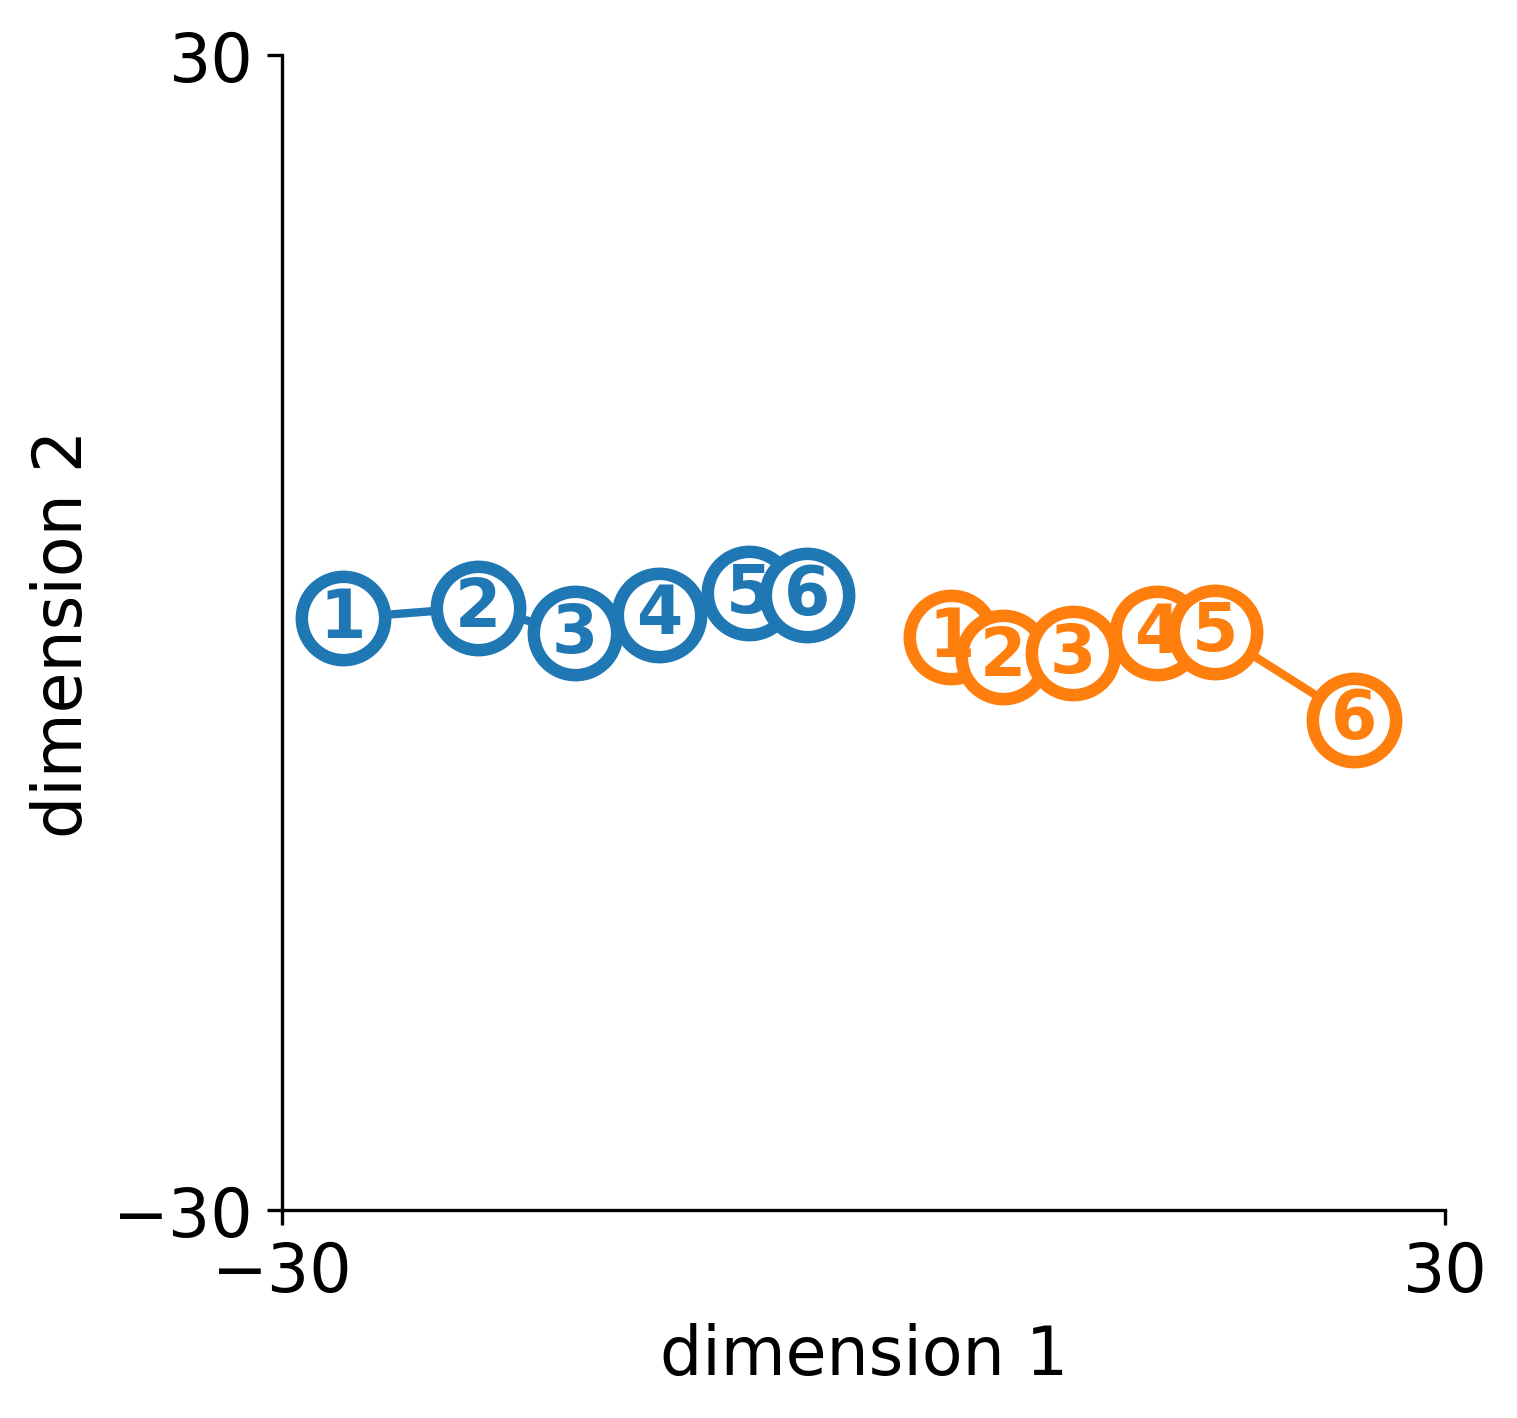

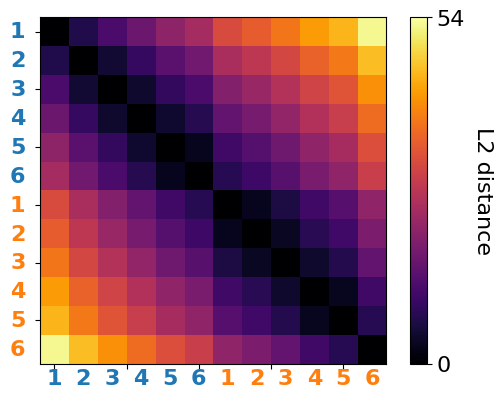

52.76272662411525


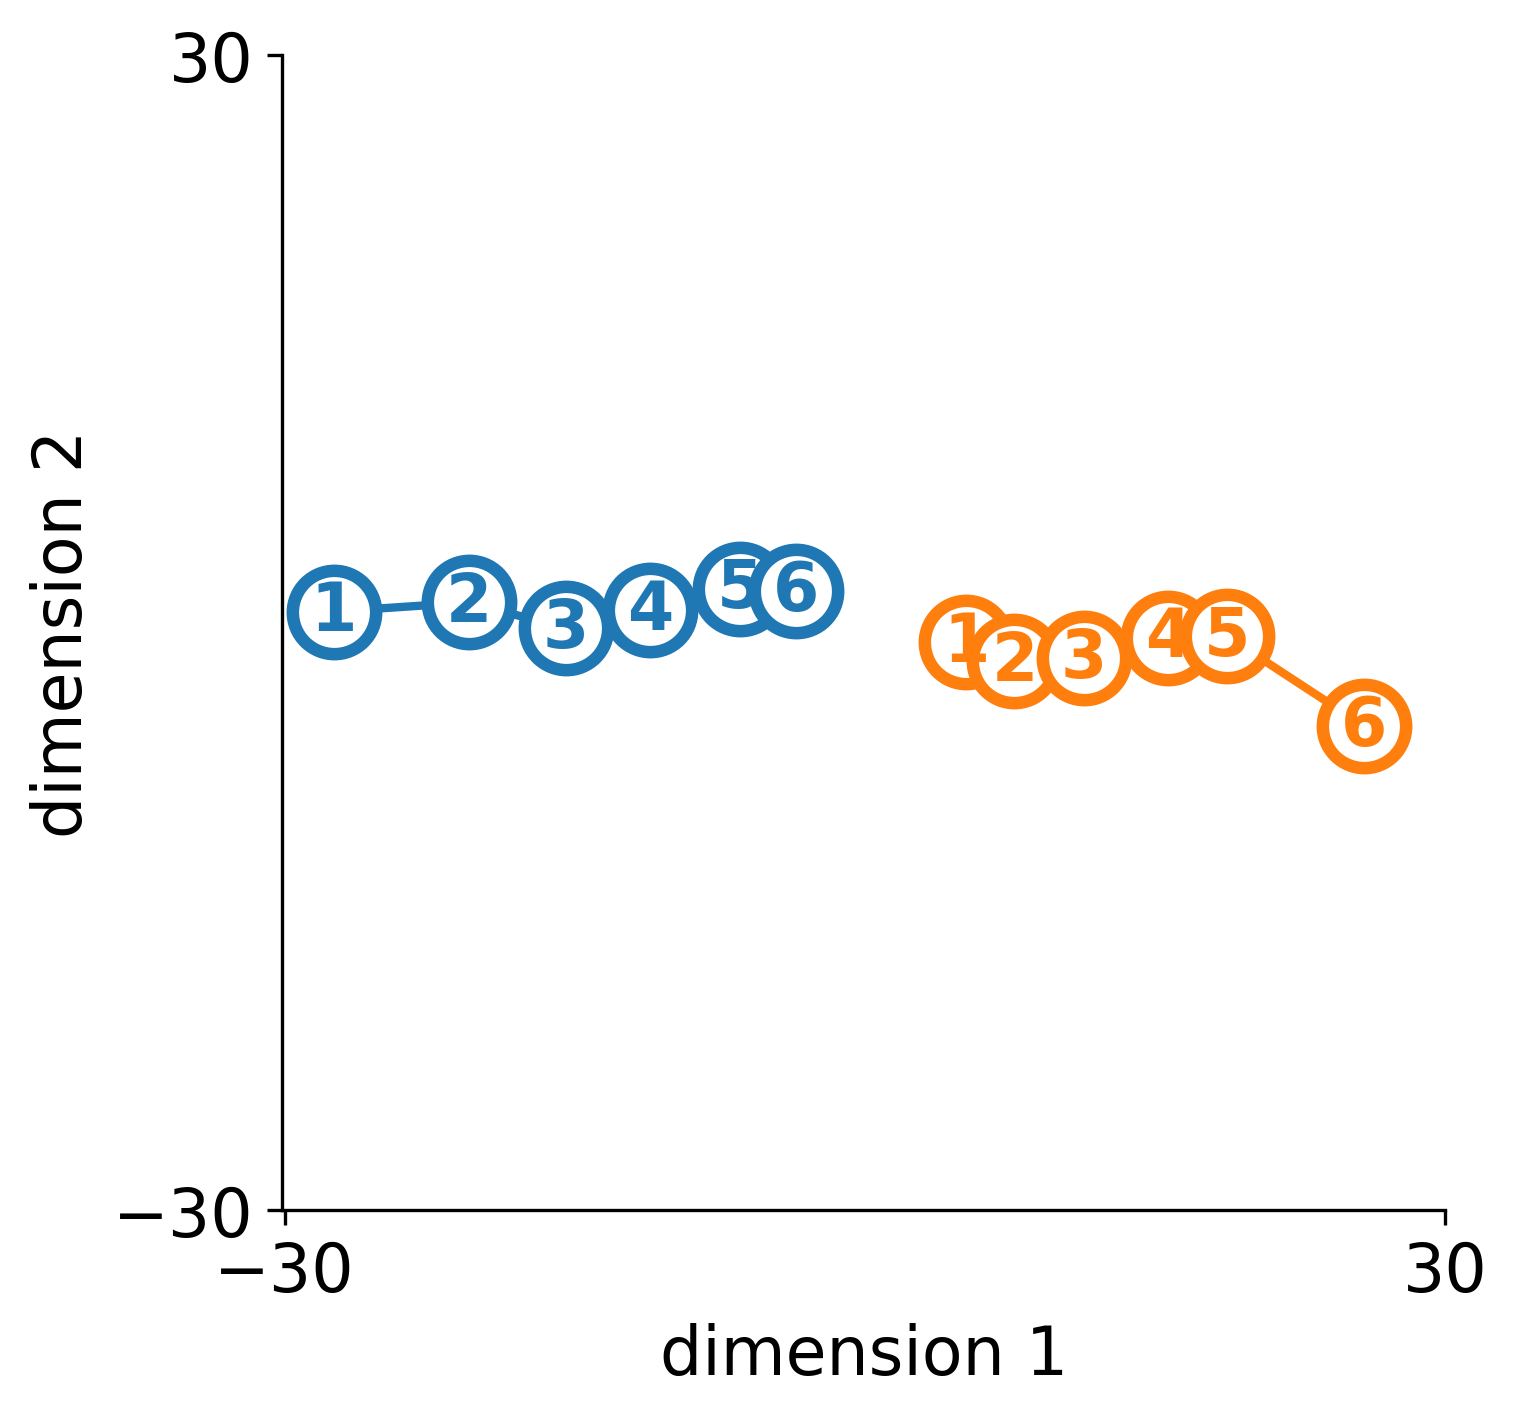

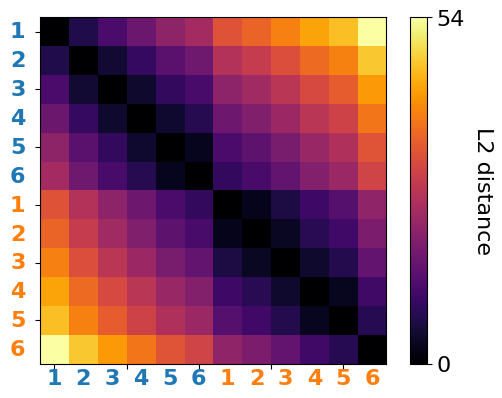

53.90699406236791


In [71]:
from sklearn.utils import shuffle

# virtual training: pair2, labels2
# boundary training: order1[5], order2[0], label=1
num_epochs = 5
eta = 0.01
values_all = np.zeros((num_epochs+1, num_objects*2))
iters=0

# Track the mean of v for each object over epochs
mean_v_values1 = np.zeros((num_epochs+2, num_objects))
mean_v_values2 = np.zeros((num_epochs+2, num_objects))

for i in range(num_objects):
    s_i1_s = W1 @ one_hot_vectors1[i]
    s_i1_c = Wc @ one_hot_context[0]
    s_i1 = torch.concatenate((s_i1_s,s_i1_c))
    v_i1 = P @ s_i1
    mean_v_values1[0, i] = v_i1.mean().item()

    s_i2_s = W2 @ one_hot_vectors2[i]
    s_i2_c = Wc @ one_hot_context[1]
    s_i2 = torch.concatenate((s_i2_s,s_i2_c))
    v_i2 = P @ s_i2
    mean_v_values2[0, i] = v_i2.mean().item()
    
pairs2, labels2 = shuffle(pairs2, labels2)
P_record = []
for epoch in tqdm(range(num_epochs+1), desc="Training Progress"):

    P_record += [P.clone()]
        
    for context in range(2):
        for obj in range(6):
            if context == 0:
                values_all[iters, obj] = \
                (P@torch.concatenate((W1 @ one_hot_vectors1[obj], Wc @ one_hot_context[0]))).mean()
            else:
                values_all[iters, obj+num_objects] = \
                (P@torch.concatenate((W2 @ one_hot_vectors2[obj], Wc @ one_hot_context[1]))).mean()
                

    #boundary training
    s_boundary_low = torch.concatenate((W1 @ one_hot_vectors1[-1], Wc @ one_hot_context[0]))
    s_new = torch.concatenate((W2 @ one_hot_vectors2[0], Wc @ one_hot_context[1]))

    v_boundary_low = P @ s_boundary_low
    v_new = P @ s_new

    e_boundary = error_function(v_boundary_low, v_new, 1)
    epoch_error += e_boundary.mean().item()
    P_pre = P.clone()
    
    context_learning_rate_ratio = 4
    P[:,:hidden_dim] += eta * torch.outer(e_boundary, (s_new-s_boundary_low)[:hidden_dim])
    P[:,hidden_dim:] += context_learning_rate_ratio * eta * torch.outer(e_boundary, (s_new-s_boundary_low)[hidden_dim:])

    
    iters += 1
    for i in range(num_objects):
        s_i1_s = W1 @ one_hot_vectors1[i]
        s_i1_c = Wc @ one_hot_context[0]
        s_i1 = torch.concatenate((s_i1_s,s_i1_c))
        v_i1 = P @ s_i1
        mean_v_values1[epoch+1, i] = v_i1.mean().item()

        s_i2_s = W2 @ one_hot_vectors2[i]
        s_i2_c = Wc @ one_hot_context[1]
        s_i2 = torch.concatenate((s_i2_s,s_i2_c))
        v_i2 = P @ s_i2
        mean_v_values2[epoch+1, i] = v_i2.mean().item()
summed_v_values1 = mean_v_values1[-1, :]
learned_ranking1 = sorted(range(num_objects), key=lambda i: summed_v_values1[i])

summed_v_values2 = mean_v_values2[-1, :]
learned_ranking2 = sorted(range(num_objects), key=lambda i: summed_v_values2[i])

print(f"Ground truth ranking: {ground_truth_ranking1}")
print(f"Learned ranking: {learned_ranking1}")
print(f"Mean v values: {summed_v_values1}")

print(f"Ground truth ranking: {ground_truth_ranking2}")
print(f"Learned ranking: {learned_ranking2}")
print(f"Mean v values: {summed_v_values2}")
max_mds = 0
max_heat = 0
for i in range(num_epochs):
    P = P_record[i]
    _mds,output1, output2 = fig_MDS(W1, W2, P, Wc, 10, False)
    if _mds>max_mds:
        max_mds = _mds
    _heat = plot_heat_map(output1, output2, 99, False)
    print(_heat)
    if _heat>max_heat:
        max_heat = _heat
print('max:', max_heat)
for i in range(num_epochs):
    P = P_record[i]
    output1, output2 = fig_MDS(W1, W2, P, Wc, round(max_mds, -1))
    max_c = plot_heat_map(output1, output2, round(max_heat, 0))

In [2]:
import torch
import numpy as np

def average_cosine(vectors):

    # Normalize each vector
    vectors_norm = vectors / vectors.norm(dim=1, keepdim=True)

    # Compute the cosine similarity matrix (dot product of normalized vectors)
    cosine_similarities = vectors_norm @ vectors_norm.T

    # Extract the upper triangle of the matrix, excluding the diagonal
    num_objects = vectors.shape[0]
    i, j = torch.triu_indices(num_objects, num_objects, offset=1)
    cosine_similarities_upper = cosine_similarities[i, j]
    # Calculate the average cosine similarity
    average_cosine = cosine_similarities_upper.mean().item()

    
    return average_cosine


def gen_W(num_objects, dim, target_cosine):
    # Define ranges
    sparsity_range = (0.002, 0.01)
    # Initialize the vectors tensor with random sparsity
    vectors = torch.zeros((num_objects, dim), dtype=torch.float)
    num_ones = torch.randint(int(sparsity_range[0] * dim), int(sparsity_range[1] * dim + 1), (num_objects,))
    for i in range(num_objects):
        ones_indices = torch.randperm(dim)[:num_ones[i]]
        vectors[i, ones_indices] = 1

    cos = average_cosine(vectors)
    if target_cosine==0 and cos!=0:
        vectors = torch.zeros((num_objects, dim), dtype=torch.float)
        num_ones = torch.randint(int(sparsity_range[0] * dim), int(sparsity_range[1] * dim + 1), (num_objects,))
        for i in range(num_objects):
            ones_indices = torch.randperm(dim)[:num_ones[i]]
            vectors[i, ones_indices] = 1

        cos = average_cosine(vectors)
        

    while(cos<target_cosine):
        # Randomly pick a pair of objects i and j
        indices = torch.randperm(num_objects)[:2]
        i, j = indices[0], indices[1]
        vi = vectors[i, :]
        vj = vectors[j, :]

        # Identify dimensions where only one of them has a 1 using XOR
        diff_indices = torch.nonzero(vi.int() ^ vj.int()).flatten()
        if len(diff_indices) > 0:
            # Randomly pick one such dimension
            dim_to_change = diff_indices[torch.randint(len(diff_indices), (1,)).item()]
        else:
            continue

        # Determine which vector has 0 at the chosen dimension
        if vi[dim_to_change] == 0:
            index_to_modify = i
        else:
            index_to_modify = j

        # Set the value of this object at the chosen dimension to 1
        vectors[index_to_modify, dim_to_change] = 1

        # Find a dimension in the same object that currently equals 1
        ones_indices = torch.nonzero(vectors[index_to_modify] == 1).flatten()
        ones_indices = ones_indices[ones_indices != dim_to_change]  # Exclude the modified dimension

        # Randomly pick one such dimension to set to 0
        dim_to_zero = ones_indices[torch.randint(len(ones_indices), (1,)).item()]
        vectors[index_to_modify, dim_to_zero] = 0

        # Compute the average cosine again
        cos = average_cosine(vectors)
#     print(cos)
    return vectors.T



In [95]:
shuffle(train_pairs, train_labels)

[[(1, 2), (4, 5), (3, 4), (2, 3), (0, 1)], [1, 1, 1, 1, 1]]

In [177]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

# Define the number of objects and dimensions
num_objects = 6
input_dim = num_objects
context_dim = 2
hidden_dim = 1000
hidden_context_dim = 1000
output_dim = 100

# Ground truth ranking
ground_truth_ranking1 = [0,1,2,3,4,5]
ground_truth_ranking2 = [0,1,2,3,4,5]
ground_truth_ranking = list(range(num_objects))

# Create all possible pairs of objects

test_pairs = [(i, j) for i in range(num_objects) for j in range(num_objects) if ((i != j) and (i-j!=1) and (j-i!=1))]
test_labels = [1 if ground_truth_ranking.index(i) < ground_truth_ranking.index(j) else -1 for i, j in test_pairs]

train_pairs = [(i, i+1) for i in range(num_objects-1)]
train_labels = [1 for i, j in train_pairs]

# pairs1 = [(i, j) for i in range(num_objects) for j in range(num_objects) if i != j]
# labels1 = [(1 if ground_truth_ranking1.index(i) < ground_truth_ranking1.index(j) else -1) for i, j in pairs1]
# pairs2 = [(i, j) for i in range(num_objects) for j in range(num_objects) if i != j]
# labels2 = [(1 if ground_truth_ranking2.index(i) < ground_truth_ranking2.index(j) else -1) for i, j in pairs2]

# One-hot encode the input
one_hot_vectors1 = torch.eye(num_objects)
one_hot_vectors2 = torch.eye(num_objects)

one_hot_context = torch.eye(context_dim)

# Initialize W (fixed, random)
# W1 = torch.randn(hidden_dim, input_dim)
# W2 = torch.randn(hidden_dim, input_dim)
repeat_all_acc_0 = []
repeat_all_acc_0_1 = []
repeat_all_acc_0_short = []
repeat_all_acc_0_1_short = []

for repeat in tqdm(range(100)):
    for cos in [0,0.1]:
        W1 = gen_W(num_objects, hidden_dim, cos)
        W2 = gen_W(num_objects, hidden_dim, cos)
        Wc = gen_W(context_dim, hidden_context_dim, cos)

        # Wc = 10.*torch.randn(hidden_context_dim, context_dim) 

        # Initialize P (trainable)
        P = torch.randn(output_dim, hidden_dim+hidden_context_dim) * 0.1

        # Learning rate
        eta = 0.01

        # Number of epochs
        num_epochs = 50

        # Define the error function
        def error_function(v_i, v_j, label):
            error = torch.maximum((label * (v_i - v_j) +1), torch.tensor(0))*label
            return error

        # Track the mean of v for each object over epochs
        mean_v_values1 = np.zeros((num_epochs*len(train_pairs)+1, num_objects))
        mean_v_values2 = np.zeros((num_epochs*len(train_pairs)+1, num_objects))

        for i in range(num_objects):
            s_i1_s = W1 @ one_hot_vectors1[i]
            s_i1_c = Wc @ one_hot_context[0]
            v_i1 = P @ torch.concatenate((s_i1_s,s_i1_c))
            mean_v_values1[0, i] = v_i1.mean().item()

            s_i2_s = W2 @ one_hot_vectors2[i]
            s_i2_c = Wc @ one_hot_context[1]
            v_i2 = P @ torch.concatenate((s_i2_s,s_i2_c))
            mean_v_values2[0, i] = v_i2.mean().item()

        # Training loop
        errors = []
        iters=0
        P_record = []
        all_acc_short = []
        all_correct_1 = False
        all_correct_2 = False
        for epoch in range(num_epochs):
            if epoch in [1,3,5,9]:
                P_record += [P.clone()]
            epoch_error = 0
#             pairs2, labels2 = shuffle(pairs2, labels2)
#             pairs1, labels1 = shuffle(pairs1, labels1)
            train_pairs1, train_labels1 = shuffle(train_pairs, train_labels)
            train_pairs2, train_labels2 = shuffle(train_pairs, train_labels)
#             for (i1, j1), label1, (i2, j2), label2 in zip(pairs1, labels1, pairs2, labels2):
            for (i1, j1), label1, (i2, j2), label2 in zip(train_pairs1, train_labels1, train_pairs2, train_labels2):
                #first linear order
                s_i1_s = W1 @ one_hot_vectors1[i1]
                s_j1_s = W1 @ one_hot_vectors1[j1]
                s_i1_c = Wc @ one_hot_context[0]
                s_j1_c = Wc @ one_hot_context[0]

                s_i1 = torch.concatenate((s_i1_s,s_i1_c))
                s_j1 = torch.concatenate((s_j1_s,s_i1_c))

                v_i1 = P @ s_i1
                v_j1 = P @ s_j1

                e1 = error_function(v_i1, v_j1, label1)
                epoch_error += e1.mean().item()
                if not all_correct_1:
                    P += eta * torch.outer(e1, (s_j1-s_i1))

                #second linear order
                s_i2_s = W2 @ one_hot_vectors2[i2]
                s_j2_s = W2 @ one_hot_vectors2[j2]
                s_i1_c = Wc @ one_hot_context[1]
                s_j1_c = Wc @ one_hot_context[1]

                s_i2 = torch.concatenate((s_i2_s,s_i2_c))
                s_j2 = torch.concatenate((s_j2_s,s_i2_c))


                v_i2 = P @ s_i2
                v_j2 = P @ s_j2

                e2 = error_function(v_i2, v_j2, label2)
                epoch_error += e2.mean().item()
                if not all_correct_2:
                    P += eta * torch.outer(e2, (s_j2-s_i2))
                # Compute the mean v values for each object
                for i in range(num_objects):
                    s_i1_s = W1 @ one_hot_vectors1[i]
                    s_i1_c = Wc @ one_hot_context[0]
                    v_i1 = P @ torch.concatenate((s_i1_s,s_i1_c))
                    mean_v_values1[iters+1, i] = v_i1.mean().item()

                    s_i2_s = W2 @ one_hot_vectors2[i]
                    s_i2_c = Wc @ one_hot_context[1]
                    v_i2 = P @ torch.concatenate((s_i2_s,s_i2_c))
                    mean_v_values2[iters+1, i] = v_i2.mean().item()
                iters+=1
                
                correct1 = 0
                correct2 = 0
                for i in range(6):
                    for j in range(i+1, 6):
                        if mean_v_values1[iters,i]<mean_v_values1[iters,j]:
                            correct1 += 1
                        if mean_v_values2[iters,i]<mean_v_values2[iters,j]:
                            correct2 += 1
                correct = correct1 + correct2
                if correct1 == 15:
                    all_correct_1 = True
                else:
                    all_correct_1 = False
                if correct2 == 15:
                    all_correct_2 = True
                else:
                    all_correct_2 = False
                acc = correct/30*100
                all_acc_short += [acc]
            errors.append(epoch_error / (num_objects*2))
            if cos == 0:
                repeat_all_acc_0_short += [all_acc_short]
            elif cos==0.1:
                repeat_all_acc_0_1_short += [all_acc_short]
            else:
                print('error')

        num_epochs = 5
        eta = 0.01
        values_all = np.zeros((num_epochs+1, num_objects*2))
        iters=0

        # Track the mean of v for each object over epochs
        mean_v_values1 = np.zeros((num_epochs+2, num_objects))
        mean_v_values2 = np.zeros((num_epochs+2, num_objects))

        for i in range(num_objects):
            s_i1_s = W1 @ one_hot_vectors1[i]
            s_i1_c = Wc @ one_hot_context[0]
            s_i1 = torch.concatenate((s_i1_s,s_i1_c))
            v_i1 = P @ s_i1
            mean_v_values1[0, i] = v_i1.mean().item()

            s_i2_s = W2 @ one_hot_vectors2[i]
            s_i2_c = Wc @ one_hot_context[1]
            s_i2 = torch.concatenate((s_i2_s,s_i2_c))
            v_i2 = P @ s_i2
            mean_v_values2[0, i] = v_i2.mean().item()

        pairs2, labels2 = shuffle(pairs2, labels2)
        P_record = []
        all_acc = []
        for epoch in range(num_epochs+1):

            P_record += [P.clone()]

            for context in range(2):
                for obj in range(6):
                    if context == 0:
                        values_all[iters, obj] = \
                        (P@torch.concatenate((W1 @ one_hot_vectors1[obj], Wc @ one_hot_context[0]))).mean()
                    else:
                        values_all[iters, obj+num_objects] = \
                        (P@torch.concatenate((W2 @ one_hot_vectors2[obj], Wc @ one_hot_context[1]))).mean()

            context_learning_rate_ratio = 6
            #boundary training
            s_boundary_low = torch.concatenate((W1 @ one_hot_vectors1[-1], Wc @ one_hot_context[0]))
            s_new = torch.concatenate((W2 @ one_hot_vectors2[0], Wc @ one_hot_context[1]))

            v_boundary_low = P @ s_boundary_low
            v_new = P @ s_new

            e_boundary = error_function(v_boundary_low, v_new, 1)
            epoch_error += e_boundary.mean().item()
            P_pre = P.clone()
            P[:,:hidden_dim] += eta * torch.outer(e_boundary, (s_new-s_boundary_low)[:hidden_dim])
            P[:,hidden_dim:] += context_learning_rate_ratio * eta * torch.outer(e_boundary, (s_new-s_boundary_low)[hidden_dim:])


            iters += 1
            for i in range(num_objects):
                s_i1_s = W1 @ one_hot_vectors1[i]
                s_i1_c = Wc @ one_hot_context[0]
                s_i1 = torch.concatenate((s_i1_s,s_i1_c))
                v_i1 = P @ s_i1
                mean_v_values1[epoch+1, i] = v_i1.mean().item()

                s_i2_s = W2 @ one_hot_vectors2[i]
                s_i2_c = Wc @ one_hot_context[1]
                s_i2 = torch.concatenate((s_i2_s,s_i2_c))
                v_i2 = P @ s_i2
                mean_v_values2[epoch+1, i] = v_i2.mean().item()
            correct = 0
            for i in range(6):
                for j in range(6):
                    if mean_v_values1[epoch,i]<mean_v_values2[epoch, j]:
                        correct += 1
            acc = correct /36 * 100
            all_acc += [acc] 
        if cos == 0:
            repeat_all_acc_0 += [all_acc]
        elif cos==0.1:
            repeat_all_acc_0_1 += [all_acc]
        else:
            print('error')


  0%|          | 0/100 [00:00<?, ?it/s]

In [169]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

# Define the number of objects and dimensions
num_objects = 6
input_dim = num_objects
context_dim = 2
hidden_dim = 10000
hidden_context_dim = 10000
output_dim = 100

# Ground truth ranking
ground_truth_ranking1 = [0,1,2,3,4,5]
ground_truth_ranking2 = [0,1,2,3,4,5]
ground_truth_ranking = list(range(num_objects))

# Create all possible pairs of objects

test_pairs = [(i, j) for i in range(num_objects) for j in range(num_objects) if ((i != j) and (i-j!=1) and (j-i!=1))]
test_labels = [1 if ground_truth_ranking.index(i) < ground_truth_ranking.index(j) else -1 for i, j in test_pairs]

train_pairs = [(i, i+1) for i in range(num_objects-1)]
train_labels = [1 for i, j in train_pairs]

# pairs1 = [(i, j) for i in range(num_objects) for j in range(num_objects) if i != j]
# labels1 = [(1 if ground_truth_ranking1.index(i) < ground_truth_ranking1.index(j) else -1) for i, j in pairs1]
# pairs2 = [(i, j) for i in range(num_objects) for j in range(num_objects) if i != j]
# labels2 = [(1 if ground_truth_ranking2.index(i) < ground_truth_ranking2.index(j) else -1) for i, j in pairs2]

# One-hot encode the input
one_hot_vectors1 = torch.eye(num_objects)
one_hot_vectors2 = torch.eye(num_objects)

one_hot_context = torch.eye(context_dim)

# Initialize W (fixed, random)
# W1 = torch.randn(hidden_dim, input_dim)
# W2 = torch.randn(hidden_dim, input_dim)
repeat_all_acc_0 = []
repeat_all_acc_0_1 = []
repeat_all_acc_0_short = []
repeat_all_acc_0_1_short = []

for repeat in tqdm(range(10)):
    for cos in [0, 0.1]:
        W1 = gen_W(num_objects, hidden_dim, cos)
        W2 = gen_W(num_objects, hidden_dim, cos)
        Wc = gen_W(context_dim, hidden_context_dim, cos)

        # Wc = 10.*torch.randn(hidden_context_dim, context_dim) 

        # Initialize P (trainable)
        P = torch.randn(output_dim, hidden_dim+hidden_context_dim) * 0.1

        # Learning rate
        eta = 0.1

        # Number of epochs
        num_epochs = 50

        # Define the error function
        def error_function(v_i, v_j, label):
            error = torch.sign(torch.maximum((label * (v_i - v_j) +1), torch.tensor(0))*label)
            return error

        # Track the mean of v for each object over epochs
        mean_v_values1 = np.zeros((num_epochs*len(train_pairs)+1, num_objects))
        mean_v_values2 = np.zeros((num_epochs*len(train_pairs)+1, num_objects))

        for i in range(num_objects):
            s_i1_s = W1 @ one_hot_vectors1[i]
            s_i1_c = Wc @ one_hot_context[0]
            v_i1 = P @ torch.concatenate((s_i1_s,s_i1_c))
            mean_v_values1[0, i] = v_i1.mean().item()

            s_i2_s = W2 @ one_hot_vectors2[i]
            s_i2_c = Wc @ one_hot_context[1]
            v_i2 = P @ torch.concatenate((s_i2_s,s_i2_c))
            mean_v_values2[0, i] = v_i2.mean().item()

        # Training loop
        errors = []
        iters=0
        P_record = []
        all_acc_short = []
        all_correct_1 = False
        all_correct_2 = False
        for epoch in range(num_epochs):
            if epoch in [1,3,5,9]:
                P_record += [P.clone()]
            epoch_error = 0
#             pairs2, labels2 = shuffle(pairs2, labels2)
#             pairs1, labels1 = shuffle(pairs1, labels1)
            train_pairs1, train_labels1 = shuffle(train_pairs, train_labels)
            train_pairs2, train_labels2 = shuffle(train_pairs, train_labels)
#             for (i1, j1), label1, (i2, j2), label2 in zip(pairs1, labels1, pairs2, labels2):
            for (i1, j1), label1, (i2, j2), label2 in zip(train_pairs1, train_labels1, train_pairs2, train_labels2):
                index = np.random.randint(0,len(train_pairs1))
                (i1, j1), label1, (i2, j2), label2 = train_pairs1[index], train_labels1[index], train_pairs2[index], train_labels2[index]
                #first linear order
                s_i1_s = W1 @ one_hot_vectors1[i1]
                s_j1_s = W1 @ one_hot_vectors1[j1]
                s_i1_c = Wc @ one_hot_context[0]
                s_j1_c = Wc @ one_hot_context[0]

                s_i1 = torch.concatenate((s_i1_s,s_i1_c))
                s_j1 = torch.concatenate((s_j1_s,s_i1_c))

                v_i1 = P @ s_i1
                v_j1 = P @ s_j1

                e1 = error_function(v_i1, v_j1, label1)
                epoch_error += e1.mean().item()
                if True: #not all_correct_1:
                    P += eta * torch.outer(e1, (s_j1-s_i1))

                #second linear order
                s_i2_s = W2 @ one_hot_vectors2[i2]
                s_j2_s = W2 @ one_hot_vectors2[j2]
                s_i1_c = Wc @ one_hot_context[1]
                s_j1_c = Wc @ one_hot_context[1]

                s_i2 = torch.concatenate((s_i2_s,s_i2_c))
                s_j2 = torch.concatenate((s_j2_s,s_i2_c))


                v_i2 = P @ s_i2
                v_j2 = P @ s_j2

                e2 = error_function(v_i2, v_j2, label2)
                epoch_error += e2.mean().item()
                if True:#not all_correct_2:
                    P += eta * torch.outer(e2, (s_j2-s_i2))
                # Compute the mean v values for each object
                for i in range(num_objects):
                    s_i1_s = W1 @ one_hot_vectors1[i]
                    s_i1_c = Wc @ one_hot_context[0]
                    v_i1 = P @ torch.concatenate((s_i1_s,s_i1_c))
                    mean_v_values1[iters+1, i] = v_i1.mean().item()

                    s_i2_s = W2 @ one_hot_vectors2[i]
                    s_i2_c = Wc @ one_hot_context[1]
                    v_i2 = P @ torch.concatenate((s_i2_s,s_i2_c))
                    mean_v_values2[iters+1, i] = v_i2.mean().item()
                iters+=1
                
                correct1 = 0
                correct2 = 0
                for i in range(6):
                    for j in range(i+1, 6):
                        if mean_v_values1[iters,i]<mean_v_values1[iters,j]:
                            correct1 += 1
                        if mean_v_values2[iters,i]<mean_v_values2[iters,j]:
                            correct2 += 1
                correct = correct1 + correct2
                if correct1 == 15:
                    all_correct_1 = True
                else:
                    all_correct_1 = False
                if correct2 == 15:
                    all_correct_2 = True
                else:
                    all_correct_2 = False
                acc = correct/30*100
                all_acc_short += [acc]
            errors.append(epoch_error / (num_objects*2))
            if cos == 0:
                repeat_all_acc_0_short += [all_acc_short]
            elif cos==0.1:
                repeat_all_acc_0_1_short += [all_acc_short]
            else:
                print('error')

        num_epochs = 6
        eta = 0.05
        values_all = np.zeros((num_epochs+1, num_objects*2))
        iters=0

        # Track the mean of v for each object over epochs
        mean_v_values1 = np.zeros((num_epochs+2, num_objects))
        mean_v_values2 = np.zeros((num_epochs+2, num_objects))

        for i in range(num_objects):
            s_i1_s = W1 @ one_hot_vectors1[i]
            s_i1_c = Wc @ one_hot_context[0]
            s_i1 = torch.concatenate((s_i1_s,s_i1_c))
            v_i1 = P @ s_i1
            mean_v_values1[0, i] = v_i1.mean().item()

            s_i2_s = W2 @ one_hot_vectors2[i]
            s_i2_c = Wc @ one_hot_context[1]
            s_i2 = torch.concatenate((s_i2_s,s_i2_c))
            v_i2 = P @ s_i2
            mean_v_values2[0, i] = v_i2.mean().item()

        pairs2, labels2 = shuffle(pairs2, labels2)
        P_record = []
        all_acc = []
        for epoch in range(num_epochs+1):

            P_record += [P.clone()]

            for context in range(2):
                for obj in range(6):
                    if context == 0:
                        values_all[iters, obj] = \
                        (P@torch.concatenate((W1 @ one_hot_vectors1[obj], Wc @ one_hot_context[0]))).mean()
                    else:
                        values_all[iters, obj+num_objects] = \
                        (P@torch.concatenate((W2 @ one_hot_vectors2[obj], Wc @ one_hot_context[1]))).mean()

            context_learning_rate_ratio = 8
            #boundary training
            s_boundary_low = torch.concatenate((W1 @ one_hot_vectors1[-1], Wc @ one_hot_context[0]))
            s_new = torch.concatenate((W2 @ one_hot_vectors2[0], Wc @ one_hot_context[1]))

            v_boundary_low = P @ s_boundary_low
            v_new = P @ s_new

            e_boundary = error_function(v_boundary_low, v_new, 1)
            epoch_error += e_boundary.mean().item()
            P_pre = P.clone()
            P[:,:hidden_dim] += eta * torch.outer(e_boundary, (s_new-s_boundary_low)[:hidden_dim])
            P[:,hidden_dim:] += context_learning_rate_ratio * eta * torch.outer(e_boundary, (s_new-s_boundary_low)[hidden_dim:])


            iters += 1
            for i in range(num_objects):
                s_i1_s = W1 @ one_hot_vectors1[i]
                s_i1_c = Wc @ one_hot_context[0]
                s_i1 = torch.concatenate((s_i1_s,s_i1_c))
                v_i1 = P @ s_i1
                mean_v_values1[epoch+1, i] = v_i1.mean().item()

                s_i2_s = W2 @ one_hot_vectors2[i]
                s_i2_c = Wc @ one_hot_context[1]
                s_i2 = torch.concatenate((s_i2_s,s_i2_c))
                v_i2 = P @ s_i2
                mean_v_values2[epoch+1, i] = v_i2.mean().item()
            correct = 0
            for i in range(12):
                for j in range(i+1, 12):
                    if i <6:
                        vi = mean_v_values1[epoch,i]
                    else:
                        vi = mean_v_values2[epoch,i-6]
                    if j < 6:
                        vj = mean_v_values1[epoch,j]
                    else:
                        vj = mean_v_values2[epoch, j-6]
                    if vi<vj:
                        correct += 1
#                     print(i,j,vi,vj)

            acc = correct /66 * 100
            all_acc += [acc] 
        if cos == 0:
            repeat_all_acc_0 += [all_acc]
        elif cos==0.1:
            repeat_all_acc_0_1 += [all_acc]
        else:
            print('error')


  0%|          | 0/10 [00:00<?, ?it/s]

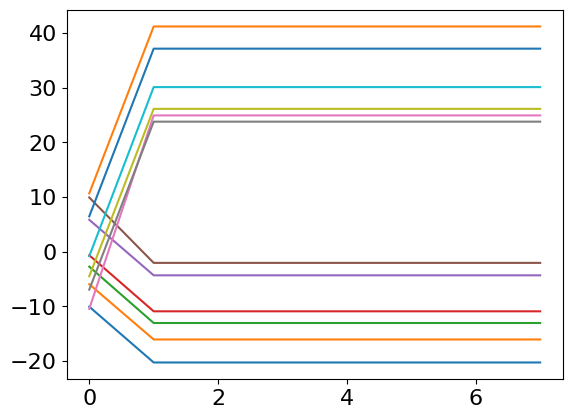

In [170]:
plt.plot(mean_v_values1)
plt.plot(mean_v_values2)

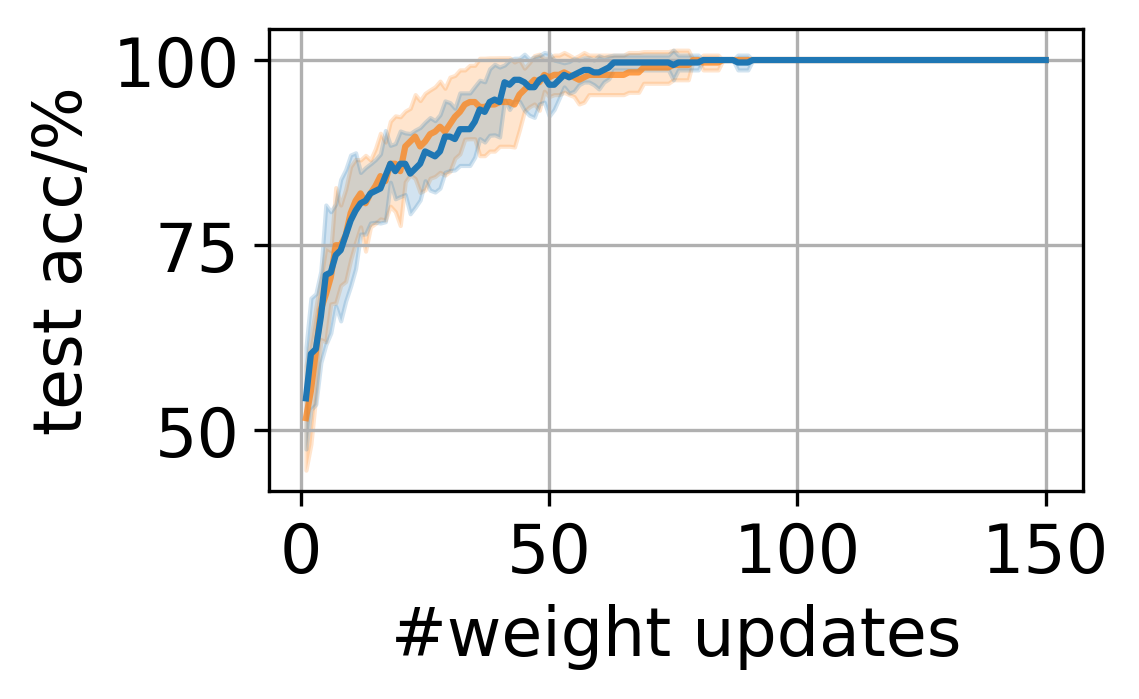

In [171]:
import matplotlib.pyplot as plt
data_array = np.array(repeat_all_acc_0_short)[:,:150]
# Calculate mean and standard deviation across the data
mean_values = np.mean(data_array, axis=0)
std_values = np.std(data_array, axis=0)


# Create an array for the iteration indices
iterations = np.arange(data_array.shape[1])+1

# Plot mean with shaded standard deviation
plt.figure(figsize=(3.5, 2), dpi=300)
data_array2 = np.array(repeat_all_acc_0_1_short)[:,:150]

# Calculate mean and standard deviation across the data
mean_values2 = np.mean(data_array2, axis=0)
std_values2 = np.std(data_array2, axis=0)


# Create an array for the iteration indices
iterations = np.arange(data_array2.shape[1])+1

# Plot mean with shaded standard deviation
plt.fill_between(iterations, mean_values2 - std_values2, mean_values2 + std_values2, color="tab:orange", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values2, label="Mean Correlation", color="tab:orange", alpha=0.7)

plt.fill_between(iterations, mean_values - std_values, mean_values + std_values, color="tab:blue", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values, label="Mean Correlation", color="tab:blue")

# epochs = iterations / 90
# plt.xticks(ticks=iterations[::90].tolist()+[450], labels=np.arange(6).astype(np.int8))
# plt.ylim(50,105)
# plt.xticks(np.arange(1,num_epochs+2,1))
# Add labels and title
# plt.title("Correlation Change Across Training Iterations")
plt.xlabel("#weight updates")
plt.ylabel("test acc/%")
# plt.legend()
plt.grid(True)

# Show the plot
plt.show()

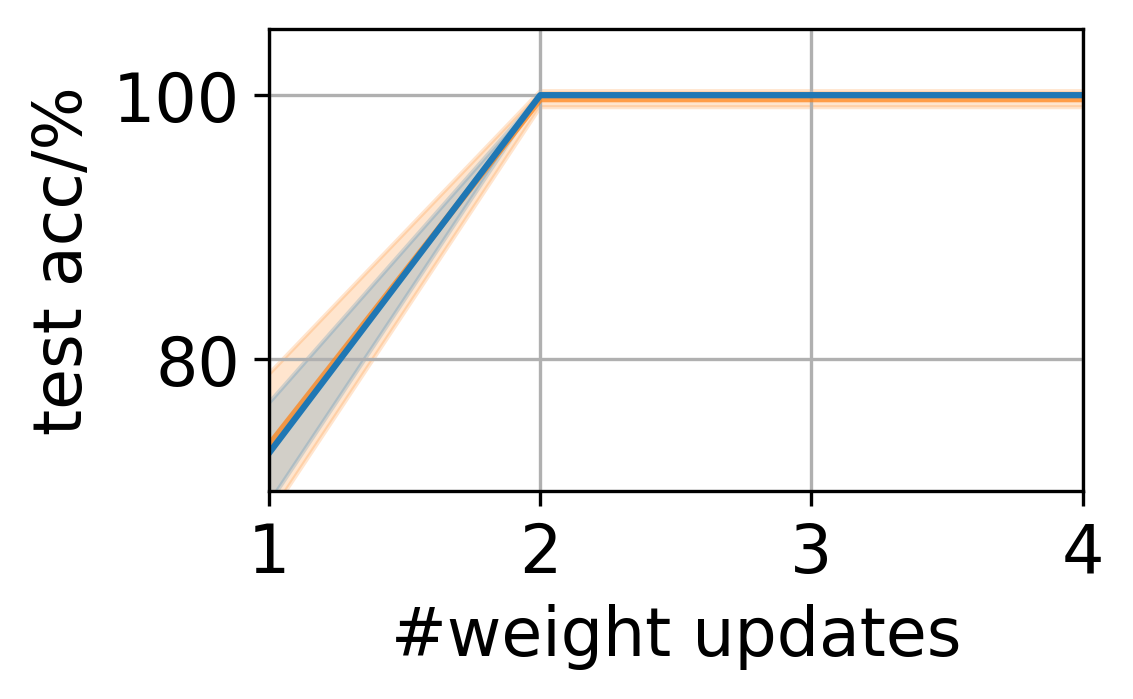

In [172]:
import matplotlib.pyplot as plt
data_array = np.array(repeat_all_acc_0)#[:,:3]
# Calculate mean and standard deviation across the data
mean_values = np.mean(data_array, axis=0)
std_values = np.std(data_array, axis=0)


# Create an array for the iteration indices
iterations = np.arange(data_array.shape[1])+1

# Plot mean with shaded standard deviation
plt.figure(figsize=(3.5, 2), dpi=300)
data_array2 = np.array(repeat_all_acc_0_1)#[:,:3]

# Calculate mean and standard deviation across the data
mean_values2 = np.mean(data_array2, axis=0)
std_values2 = np.std(data_array2, axis=0)


# Create an array for the iteration indices
iterations = np.arange(data_array2.shape[1])+1

# Plot mean with shaded standard deviation
plt.fill_between(iterations, mean_values2 - std_values2, mean_values2 + std_values2, color="tab:orange", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values2, label="Mean Correlation", color="tab:orange", alpha=0.7)

plt.fill_between(iterations, mean_values - std_values, mean_values + std_values, color="tab:blue", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values, label="Mean Correlation", color="tab:blue")

# epochs = iterations / 90
# plt.xticks(ticks=iterations[::90].tolist()+[450], labels=np.arange(6).astype(np.int8))
plt.ylim(70,105)
plt.xticks(np.arange(1,num_epochs+2,1))
plt.xlim(1,4)
# Add labels and title
# plt.title("Correlation Change Across Training Iterations")
plt.xlabel("#weight updates")
plt.ylabel("test acc/%")
# plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [155]:
iterations

array([1, 2, 3, 4, 5, 6, 7])